In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
enrich_pearson_df = pd.read_csv(f"/kaggle/input/enrich-data-node-clustering/phase2/user_train_phase_2.csv")
enrich_pearson_df.head()

In [ ]:
enrich_pearson_df.info()

In [ ]:

# --- 2. Kiểm tra phân bố và phát hiện giá trị ngoại lai ---
print("\n## 2. Kiểm tra phân bố và phát hiện giá trị ngoại lai\n")

# Lọc ra các cột số
numeric_cols = enrich_pearson_df.select_dtypes(include=np.number).columns.tolist()

# Loại bỏ các cột có thể là ID hoặc nhị phân nếu chúng không đại diện cho phân bố liên tục
# Đây là các cột mà biểu đồ phân bố không thực sự có ý nghĩa
cols_to_exclude_from_hist_box = [
    'end_year', 'user_month', 'certificate', 'assignment', 'video', 'exam',
    'cluster', 'exercise_langugage_binary_mean_1', 'label_encoded'
]
plotting_cols = [col for col in numeric_cols if col not in cols_to_exclude_from_hist_box]

# Với 42 hàng, việc vẽ tất cả các đặc trưng trên một biểu đồ có thể làm cho nó quá tải.
# Chúng ta sẽ vẽ từng nhóm để dễ phân tích.

# Phân nhóm các cột cho việc trực quan hóa
groups = {
    "Đặc trưng chung": [
        'encoded_field_sum', 'video_count', 'exercise_count', 'chapter_count',
        'user_past_course_count', 'user_time_since_last_course', 'num_prerequisites',
        'duration_days', 'remaining_time'
    ],
    "Đặc trưng mạng/cấu trúc": [
        'closeness', 'degree', 'eigenvector'
    ],
    "Đặc trưng bài tập": [
        'exercise_id_count_1', 'exercise_correct_sum_1', 'exercise_correct_mean_1',
        'exercise_num_problem_sum_1', 'exercise_attempts_sum_mean_1',
        'exercise_context_sum_1', 'exercise_diff_mean_1',
        'exercise_perc_real_completed_mean_1', 'exercise_perc_real_score_mean_1',
        'exercise_hour_entropy_1'
    ],
    "Đặc trưng video": [
        'video_watched_percentage_1', 'video_percentage_watch_time_1',
        'video_pause_count_1', 'video_time_between_views_std_1', 'video_speed_avg_1'
    ],
    "Đặc trưng bình luận/văn bản": [
        'entropy_time_comment_phase1', 'total_words_phase1', 'total_positive1',
        'total_negative1', 'total_neutral1'
    ],
    "Biến mục tiêu/điểm số": [
        'total_score'
    ]
}

for group_name, cols_in_group in groups.items():
    print(f"\n### Phân bố và Giá trị ngoại lai: {group_name} ###")
    fig, axes = plt.subplots(len(cols_in_group), 2, figsize=(15, 4 * len(cols_in_group)))
    
    # Đảm bảo axes là mảng 2D ngay cả khi chỉ có 1 cột
    if len(cols_in_group) == 1:
        axes = np.array([axes])

    for i, col in enumerate(cols_in_group):
        # Histogram + KDE
        sns.histplot(enrich_pearson_df[col], kde=True, ax=axes[i, 0], bins=min(len(enrich_pearson_df[col].unique()), 20))
        axes[i, 0].set_title(f'Phân bố của {col}', fontsize=14)
        axes[i, 0].set_xlabel(col, fontsize=12)
        axes[i, 0].set_ylabel('Tần suất / Mật độ', fontsize=12)
        
        # Box Plot
        sns.boxplot(y=enrich_pearson_df[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Box Plot của {col}', fontsize=14)
        axes[i, 1].set_ylabel(col, fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:

# --- 3. Ma trận tương quan ---
print("\n## 3. Ma trận Tương quan (Correlation Matrix)\n")

# Chọn các cột số để tính tương quan
# Loại bỏ 'Unnamed: 0' vì nó là ID
correlation_cols = [col for col in numeric_cols if col != 'Unnamed: 0']
numeric_df_for_corr = enrich_pearson_df[correlation_cols]

# Pearson Correlation
plt.figure(figsize=(20, 18))
pearson_corr = numeric_df_for_corr.corr(method='pearson')
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Ma trận Tương quan Pearson', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Spearman Correlation
plt.figure(figsize=(20, 18))
spearman_corr = numeric_df_for_corr.corr(method='spearman')
sns.heatmap(spearman_corr, annot=False, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Ma trận Tương quan Spearman', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("\n### Tương quan của các đặc trưng với 'label_encoded' (Pearson) ###")
print(pearson_corr['label_encoded'].sort_values(ascending=False))

print("\n### Tương quan của các đặc trưng với 'label_encoded' (Spearman) ###")
print(spearman_corr['label_encoded'].sort_values(ascending=False))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cấu hình hiển thị cho đồ thị
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Đường dẫn cơ sở đến thư mục chứa dữ liệu của bạn
base_data_path = "/kaggle/input/enrich-data-node-clustering"

# Giả định chúng ta sẽ load phase 4 để có đủ các đặc trưng
# Nếu bạn muốn chạy trên một phase cụ thể, hãy thay đổi số này
target_phase_for_analysis = 4 

# Load the final accumulated DataFrame (or the one you want to analyze)
current_df = pd.DataFrame()
ID_COLUMN = 'record_id' # Cột ID để merge

try:
    # Build path for the target phase file
    file_path = os.path.join(base_data_path, f"correlations/phase{target_phase_for_analysis}/user_train_phase_{target_phase_for_analysis}_spearman.csv")
    current_df = pd.read_csv(file_path)
    
    # Rename 'Unnamed: 0' to ID_COLUMN if it exists
    if 'Unnamed: 0' in current_df.columns:
        current_df.rename(columns={'Unnamed: 0': ID_COLUMN}, inplace=True)
    
    print(f"Đã tải DataFrame từ Phase {target_phase_for_analysis} để phân tích.")
    print(f"Kích thước DataFrame: {current_df.shape}")
    print(current_df.info())

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file cho Phase {target_phase_for_analysis} tại {file_path}. Vui lòng kiểm tra lại đường dẫn và tên file.")
    # Exit or handle error appropriately if the dataframe can't be loaded
    exit() 
except Exception as e:
    print(f"Lỗi khi tải DataFrame: {e}")
    exit()

# Danh sách các đặc trưng cần phân tích
features_to_analyze = ['cluster', 'closeness', 'degree', 'eigenvector']

# Lọc ra các đặc trưng thực sự có trong DataFrame
existing_features = [f for f in features_to_analyze if f in current_df.columns]

if not existing_features:
    print(f"Không tìm thấy bất kỳ đặc trưng nào trong số {features_to_analyze} trong DataFrame.")
else:
    print(f"\n--- Bắt đầu vẽ biểu đồ phân phối cho các đặc trưng: {existing_features} ---")

    # 1. Biểu đồ cho 'cluster' (Bar Plot)
    if 'cluster' in current_df.columns:
        plt.figure(figsize=(10, 6))
        # Chuyển cluster sang kiểu category để biểu đồ đẹp hơn nếu giá trị là float
        sns.countplot(data=current_df, x='cluster', palette='viridis', order=current_df['cluster'].value_counts().index)
        plt.title('Phân phối số lượng bản ghi theo Cụm (Cluster)', fontsize=16)
        plt.xlabel('ID Cụm', fontsize=12)
        plt.ylabel('Số lượng Bản ghi', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 2. Biểu đồ cho 'closeness', 'degree', 'eigenvector' (Histogram và Box Plot)
    numeric_graph_features = [f for f in ['closeness', 'degree', 'eigenvector'] if f in current_df.columns]
    
    if numeric_graph_features:
        for feature in numeric_graph_features:
            print(f"\n--- Biểu đồ phân phối cho: {feature} ---")
            
            # Histogram
            plt.figure(figsize=(12, 5))
            sns.histplot(current_df[feature].dropna(), kde=True, bins=min(current_df[feature].nunique(), 30), color='skyblue')
            plt.title(f'Phân phối Histogram của {feature}', fontsize=16)
            plt.xlabel(feature, fontsize=12)
            plt.ylabel('Tần suất / Mật độ', fontsize=12)
            plt.tight_layout()
            plt.show()

            # Box Plot
            plt.figure(figsize=(12, 2))
            sns.boxplot(x=current_df[feature].dropna(), color='lightcoral')
            plt.title(f'Box Plot của {feature}', fontsize=16)
            plt.xlabel(feature, fontsize=12)
            plt.tight_layout()
            plt.show()
    else:
        print("Không tìm thấy các đặc trưng số 'closeness', 'degree', 'eigenvector' trong DataFrame.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Đường dẫn cơ sở đến thư mục chứa dữ liệu đã làm giàu
base_data_path = "/kaggle/input/enrich-data-node-clustering"

# Danh sách các phase để lặp qua
num_phases = 4

# DataFrame tích lũy các đặc trưng qua các phase
# Khởi tạo rỗng hoặc với các cột cơ bản nếu cần
current_df = pd.DataFrame()

for phase_num in range(1, num_phases + 1):
    print(f"\n" + "="*50)
    print(f"### 📊 Bắt đầu EDA cho Phase {phase_num} ###")
    print("="*50)

    # Xây dựng đường dẫn file cho phase hiện tại
    # Giả định tên file theo format: user_train_phase_X_pearson.csv
    file_path = os.path.join(base_data_path, f"correlations/phase{phase_num}/user_train_phase_{phase_num}_pearson.csv")
    
    # Đọc dữ liệu của phase hiện tại
    try:
        new_phase_df = pd.read_csv(file_path)
        print(f"Đã đọc file: {file_path}")
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file {file_path}. Bỏ qua Phase {phase_num}.")
        continue
    
    # Nếu đây là phase đầu tiên, gán trực tiếp
    if phase_num == 1:
        current_df = new_phase_df.copy()
    else:
        # Đối với các phase sau, chúng ta cần xác định các cột mới để thêm vào.
        # Giả định rằng các cột từ phase trước đã có trong current_df.
        # Và các cột mới của phase hiện tại là những cột không trùng lặp (trừ 'Unnamed: 0')
        
        # Lấy user_id để merge
        if 'user_id' in new_phase_df.columns and 'user_id' in current_df.columns:
            # Lấy các cột mới trong new_phase_df (có thể có tiền tố số của phase hiện tại)
            # và loại bỏ các cột trùng lặp hoặc cột chỉ mục
            cols_to_add = [
                col for col in new_phase_df.columns 
                if col not in current_df.columns and col != 'Unnamed: 0'
            ]
            
            # Đảm bảo cột user_id là duy nhất trong new_phase_df để merge
            # Hoặc xem xét cách merge nếu user_id không phải là duy nhất trên mỗi phase
            
            # Merge các đặc trưng mới vào current_df
            # Sử dụng user_id và đảm bảo merge đúng cách để không làm tăng số hàng không mong muốn.
            # Với ví dụ của bạn, enrich_pearson_df có 42 hàng, có vẻ như nó là kết quả tổng hợp.
            # Nếu các file phase_pearson.csv thực sự là ma trận tương quan, thì việc merge này không phù hợp.
            # Giả định các file này là dataframes chứa features đã được làm giàu, không phải ma trận tương quan.
            
            # Cách merge an toàn hơn: chỉ merge nếu có cột chung để kết nối (ví dụ user_id)
            # Giả định các file pearson.csv là dataframe gốc đã được làm giàu chứ không phải ma trận tương quan.
            # Nếu 'Unnamed: 0' là user_id, cần đổi tên.
            
            # Lấy cột 'Unnamed: 0' làm user_id nếu nó là chỉ mục duy nhất
            if 'Unnamed: 0' in new_phase_df.columns:
                new_phase_df.rename(columns={'Unnamed: 0': 'feature_name_or_id'}, inplace=True)
                # Nếu đây là ma trận tương quan, mỗi hàng là một feature, không phải user.
                # Do đó, việc merge các ma trận tương quan lại với nhau không có ý nghĩa.
                # Giả định ở đây là các file user_train_phase_X_pearson.csv CHỨA DỮ LIỆU GỐC ĐÃ LÀM GIÀU,
                # KHÔNG phải là ma trận tương quan.
                # Nếu là ma trận tương quan, bạn cần load lại các file user_train_phase_X_train.csv
                # và tạo lại các đặc trưng từ đó để làm EDA tích lũy.

                # Theo ví dụ bạn cho: enrich_phase1_pearson_df = pd.read_csv(f"/kaggle/input/enrich-data-node-clustering/correlations/phase1/user_train_phase_1_pearson.csv")
                # Điều này chỉ ra rằng bạn đang đọc TRỰC TIẾP ma trận tương quan.
                # Nếu muốn EDA trên DỮ LIỆU THÔ ĐÃ LÀM GIÀU QUA CÁC PHASE, bạn cần thay đổi đường dẫn file
                # sang các file CSV gốc đã được làm giàu đặc trưng, ví dụ:
                # file_path = os.path.join(base_data_path, f"phase{phase_num}/user_train_phase_{phase_num}_train.csv")
                
                # Tôi sẽ tiếp tục với giả định rằng "user_train_phase_X_pearson.csv" là tên file
                # của DataFrame GỐC đã được làm giàu đặc trưng, chứ không phải là ma trận tương quan.
                # Nếu không, đoạn code này cần được sửa đổi đáng kể.

            # Để merge các đặc trưng mới vào current_df, chúng ta cần một cột chung.
            # Nếu các file .csv này là các DataFrame chứa đặc trưng cho users, thì 'user_id' là cần thiết.
            # Nếu 'Unnamed: 0' là user_id, ta cần đổi tên nó.
            if 'Unnamed: 0' in current_df.columns:
                current_df.rename(columns={'Unnamed: 0': 'user_id_or_index'}, inplace=True)
            if 'Unnamed: 0' in new_phase_df.columns:
                new_phase_df.rename(columns={'Unnamed: 0': 'user_id_or_index'}, inplace=True)

            # Lấy danh sách các cột mới trong new_phase_df không có trong current_df
            new_cols = [col for col in new_phase_df.columns if col not in current_df.columns and col != 'user_id_or_index']
            
            # Merge dựa trên 'user_id_or_index'
            if 'user_id_or_index' in current_df.columns and 'user_id_or_index' in new_phase_df.columns:
                 # Chỉ lấy các cột mới từ new_phase_df để merge
                current_df = pd.merge(current_df, new_phase_df[['user_id_or_index'] + new_cols], on='user_id_or_index', how='left')
            else:
                # Nếu không có cột chung để merge, giả định các hàng tương ứng theo thứ tự (rất rủi ro)
                # Hoặc bạn cần cung cấp một cơ chế merge rõ ràng hơn.
                # Với dữ liệu 42 hàng, có thể các cột đã được thêm vào nhưng theo tên khác.
                # Tôi sẽ dùng phương pháp gán cột trực tiếp nếu không thể merge an toàn, giả định thứ tự hàng là như nhau.
                # Đây là một giả định rủi ro nếu dữ liệu thực tế không có thứ tự cố định.
                for col in new_cols:
                    if col not in current_df.columns: # Tránh thêm trùng lặp
                        current_df[col] = new_phase_df[col]


    print(f"Kích thước DataFrame cho Phase {phase_num}: {current_df.shape}")
    print(current_df.info())

    # --- 1. Thống kê mô tả ---
    print("\n## 1. Thống kê mô tả (Descriptive Statistics)\n")
    print(current_df.describe().T)

    # --- 2. Kiểm tra phân bố và phát hiện giá trị ngoại lai ---
    print("\n## 2. Kiểm tra phân bố và Giá trị ngoại lai\n")

    # Lọc ra các cột số (loại bỏ 'Unnamed: 0' hoặc 'user_id_or_index' nếu có)
    numeric_cols = current_df.select_dtypes(include=np.number).columns.tolist()
    
    # Loại bỏ các cột có thể là ID, nhị phân, hoặc đã được biết là không liên tục
    cols_to_exclude_from_hist_box = [
        'end_year', 'user_month', 'certificate', 'assignment', 'video', 'exam',
        'cluster', 'exercise_langugage_binary_mean_1', 'label_encoded'
    ]
    # Thêm các cột có tiền tố số của các phase khác
    for i in range(1, phase_num + 1):
        cols_to_exclude_from_hist_box.extend([
            f'exercise_langugage_binary_mean_{i}'
        ])
    
    plotting_cols = [col for col in numeric_cols if col not in cols_to_exclude_from_hist_box]
    
    # Chia nhỏ việc vẽ biểu đồ thành từng nhóm để tránh quá tải
    # Dựa trên tên cột, cố gắng phân nhóm động
    
    # Tạo các nhóm cột động dựa trên tiền tố hoặc hậu tố
    dynamic_groups = {}
    for col in plotting_cols:
        if 'video_' in col:
            group_name = "Đặc trưng Video"
        elif 'exercise_' in col:
            group_name = "Đặc trưng Bài tập"
        elif 'total_words' in col or 'total_positive' in col or 'total_negative' in col or 'total_neutral' in col or 'entropy_time_comment' in col:
            group_name = "Đặc trưng Bình luận/Văn bản"
        elif col in ['closeness', 'degree', 'eigenvector', 'cluster']:
            group_name = "Đặc trưng Mạng/Cấu trúc"
        elif col in ['encoded_field_sum', 'video_count', 'exercise_count', 'chapter_count', 
                      'user_past_course_count', 'user_time_since_last_course', 
                      'num_prerequisites', 'duration_days', 'remaining_time']:
            group_name = "Đặc trưng Chung"
        elif col in ['total_score', 'label_encoded']:
            group_name = "Biến Mục tiêu"
        else:
            group_name = "Đặc trưng Khác"
        
        if group_name not in dynamic_groups:
            dynamic_groups[group_name] = []
        dynamic_groups[group_name].append(col)

    for group_name, cols_in_group in dynamic_groups.items():
        if not cols_in_group: # Bỏ qua nhóm rỗng
            continue
        print(f"\n### Phân bố và Giá trị ngoại lai: {group_name} (Phase {phase_num}) ###")
        
        # Đặt giới hạn số lượng biểu đồ trong một figure để tránh lỗi
        max_plots_per_fig = 10 # Bạn có thể điều chỉnh số này
        for i_batch in range(0, len(cols_in_group), max_plots_per_fig):
            current_batch_cols = cols_in_group[i_batch : i_batch + max_plots_per_fig]
            
            fig, axes = plt.subplots(len(current_batch_cols), 2, figsize=(15, 4 * len(current_batch_cols)))
            if len(current_batch_cols) == 1: # Xử lý trường hợp chỉ có 1 cột trong batch
                axes = np.array([axes])

            for i, col in enumerate(current_batch_cols):
                # Histogram + KDE
                sns.histplot(current_df[col], kde=True, ax=axes[i, 0], bins=min(len(current_df[col].unique()), 20))
                axes[i, 0].set_title(f'Phân bố của {col}', fontsize=12)
                axes[i, 0].set_xlabel(col, fontsize=10)
                axes[i, 0].set_ylabel('Tần suất / Mật độ', fontsize=10)
                
                # Box Plot
                sns.boxplot(y=current_df[col], ax=axes[i, 1])
                axes[i, 1].set_title(f'Box Plot của {col}', fontsize=12)
                axes[i, 1].set_ylabel(col, fontsize=10)

            plt.tight_layout()
            plt.show()


    # --- 3. Ma trận tương quan ---
    print(f"\n## 3. Ma trận Tương quan (Correlation Matrix) cho Phase {phase_num} ##\n")

    # Chọn các cột số để tính tương quan
    correlation_cols = [col for col in numeric_cols if col != 'user_id_or_index' and col != 'feature_name_or_id']
    numeric_df_for_corr = current_df[correlation_cols]
    
    # Với số lượng đặc trưng có thể tăng lên, việc trực quan hóa heatmap có thể cần điều chỉnh figsize
    num_features = numeric_df_for_corr.shape[1]
    figsize = (max(20, num_features * 0.8), max(18, num_features * 0.7)) # Điều chỉnh kích thước linh hoạt

    # Pearson Correlation
    plt.figure(figsize=figsize)
    pearson_corr = numeric_df_for_corr.corr(method='pearson')
    sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title(f'Ma trận Tương quan Pearson - Phase {phase_num}', fontsize=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Spearman Correlation
    plt.figure(figsize=figsize)
    spearman_corr = numeric_df_for_corr.corr(method='spearman')
    sns.heatmap(spearman_corr, annot=False, cmap='viridis', fmt='.2f', linewidths=.5)
    plt.title(f'Ma trận Tương quan Spearman - Phase {phase_num}', fontsize=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    print(f"\n### Tương quan của các đặc trưng với 'label_encoded' (Pearson) - Phase {phase_num} ###")
    if 'label_encoded' in pearson_corr.columns:
        print(pearson_corr['label_encoded'].sort_values(ascending=False).head(10)) # Chỉ in top 10
    else:
        print("'label_encoded' không có trong ma trận tương quan.")

    print(f"\n### Tương quan của các đặc trưng với 'label_encoded' (Spearman) - Phase {phase_num} ###")
    if 'label_encoded' in spearman_corr.columns:
        print(spearman_corr['label_encoded'].sort_values(ascending=False).head(10)) # Chỉ in top 10
    else:
        print("'label_encoded' không có trong ma trận tương quan.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Đường dẫn cơ sở đến thư mục chứa dữ liệu đã làm giàu
base_data_path = "/kaggle/input/enrich-data-node-clustering"

# Danh sách các phase để lặp qua
num_phases = 4

# DataFrame tích lũy các đặc trưng qua các phase
current_df = pd.DataFrame()

# Cột để sử dụng làm ID để merge giữa các phase.
# Thường là user_id hoặc một cột định danh duy nhất cho mỗi hàng (nếu Unnamed: 0 là đó)
# Giả định 'Unnamed: 0' là ID duy nhất của người dùng hoặc của bản ghi
# Nếu bạn có cột 'user_id' riêng biệt, hãy sử dụng nó thay thế.
ID_COLUMN = 'row_id_for_merge' # Tên tạm thời để đổi tên 'Unnamed: 0'

for phase_num in range(1, num_phases + 1):
    print(f"\n" + "="*50)
    print(f"### 📊 Bắt đầu EDA cho Phase {phase_num} ###")
    print("="*50)

    # Xây dựng đường dẫn file cho phase hiện tại
    file_path = os.path.join(base_data_path, f"phase{phase_num}/user_train_phase_{phase_num}.csv")
    
    # Đọc dữ liệu của phase hiện tại
    try:
        new_phase_df = pd.read_csv(file_path)
        print(f"Đã đọc file: {file_path}")
        
        # Đổi tên cột 'Unnamed: 0' thành ID_COLUMN để dễ quản lý
        if 'Unnamed: 0' in new_phase_df.columns:
            new_phase_df.rename(columns={'Unnamed: 0': ID_COLUMN}, inplace=True)
            print(f"Đã đổi tên 'Unnamed: 0' thành '{ID_COLUMN}' trong new_phase_df.")
        elif ID_COLUMN not in new_phase_df.columns:
            print(f"Cảnh báo: Cột '{ID_COLUMN}' hoặc 'Unnamed: 0' không tìm thấy trong {file_path}. Merge có thể không chính xác.")
            # Nếu không có cột ID, có thể cần một chiến lược khác hoặc lỗi.
            # Đối với EDA, chúng ta có thể tiếp tục với DF hiện tại nhưng cần cẩn thận.
            
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file {file_path}. Bỏ qua Phase {phase_num}.")
        continue
    
    # Logic để tích lũy DataFrame
    if phase_num == 1:
        current_df = new_phase_df.copy()
        # Đảm bảo cột ID cũng được đổi tên trong current_df cho phase 1
        if 'Unnamed: 0' in current_df.columns: # Nếu có, đổi tên ngay
            current_df.rename(columns={'Unnamed: 0': ID_COLUMN}, inplace=True)
    else:
        # Lấy danh sách các cột mới chỉ có trong new_phase_df (trừ cột ID)
        new_cols_to_add = [
            col for col in new_phase_df.columns 
            if col not in current_df.columns and col != ID_COLUMN
        ]
        
        if new_cols_to_add: # Chỉ merge nếu có cột mới để thêm
            print(f"Đang thêm các cột mới cho Phase {phase_num}: {new_cols_to_add}")
            
            if ID_COLUMN in current_df.columns and ID_COLUMN in new_phase_df.columns:
                # Chọn chỉ cột ID và các cột mới từ new_phase_df để merge
                cols_to_merge_from_new = [ID_COLUMN] + new_cols_to_add
                current_df = pd.merge(current_df, new_phase_df[cols_to_merge_from_new], on=ID_COLUMN, how='left')
                print(f"Đã merge {len(new_cols_to_add)} cột mới vào current_df.")
            else:
                print(f"Cảnh báo: Không thể merge Phase {phase_num} do thiếu cột '{ID_COLUMN}'. Thử gán trực tiếp (có thể gây sai lệch).")
                # Fallback: Gán trực tiếp nếu merge không khả thi (rủi ro nếu hàng không khớp)
                for col in new_cols_to_add:
                    if col not in current_df.columns:
                        current_df[col] = new_phase_df[col]
        else:
            print(f"Không có cột mới nào để thêm từ Phase {phase_num} vào current_df.")

    print(f"\nKích thước DataFrame sau khi tích lũy cho Phase {phase_num}: {current_df.shape}")
    print(current_df.info())

    # --- 1. Thống kê mô tả ---
    print("\n## 1. Thống kê mô tả (Descriptive Statistics)\n")
    print(current_df.describe().T)

    # --- 2. Kiểm tra phân bố và phát hiện giá trị ngoại lai ---
    print("\n## 2. Kiểm tra phân bố và Giá trị ngoại lai\n")

    # Lọc ra các cột số (loại bỏ cột ID_COLUMN)
    numeric_cols = current_df.select_dtypes(include=np.number).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != ID_COLUMN] # Đảm bảo loại bỏ cột ID

    # Các cột thường không cần biểu đồ phân bố/boxplot vì chúng là ID, nhị phân, hoặc đã biết phân loại
    # Điều chỉnh danh sách này để phù hợp với các đặc trưng của bạn qua các phase
    cols_to_exclude_from_hist_box = [
        'end_year', 'user_month', 'certificate', 'assignment', 'video', 'exam',
        'cluster', 'label_encoded', 'total_score' # total_score có thể cần nếu bạn muốn thấy phân bố điểm
    ]
    
    # Thêm các cột nhị phân hoặc phân loại khác có thể xuất hiện với tiền tố phase
    for i in range(1, phase_num + 1):
        cols_to_exclude_from_hist_box.extend([
            f'exercise_langugage_binary_mean_{i}', # Nếu đây là biến nhị phân
            # Thêm các cột tương tự khác có thể là nhị phân/phân loại theo phase
        ])
    
    # Loại bỏ các cột loại trừ khỏi danh sách vẽ biểu đồ
    plotting_cols = [col for col in numeric_cols if col not in cols_to_exclude_from_hist_box]
    
    # Tạo các nhóm cột động để dễ quản lý biểu đồ
    dynamic_groups = {}
    for col in plotting_cols:
        # Cố gắng nhóm dựa trên tiền tố hoặc từ khóa
        if 'video_' in col:
            group_name = "Đặc trưng Video"
        elif 'exercise_' in col:
            group_name = "Đặc trưng Bài tập"
        elif 'total_words' in col or 'total_positive' in col or 'total_negative' in col or 'total_neutral' in col or 'entropy_time_comment' in col:
            group_name = "Đặc trưng Bình luận/Văn bản"
        elif col in ['closeness', 'degree', 'eigenvector', 'cluster']:
            group_name = "Đặc trưng Mạng/Cấu trúc"
        elif col in ['encoded_field_sum', 'video_count', 'exercise_count', 'chapter_count', 
                      'user_past_course_count', 'user_time_since_last_course', 
                      'num_prerequisites', 'duration_days', 'remaining_time']:
            group_name = "Đặc trưng Chung"
        else:
            group_name = "Đặc trưng Khác" # Các cột không khớp với nhóm nào trên
        
        if group_name not in dynamic_groups:
            dynamic_groups[group_name] = []
        dynamic_groups[group_name].append(col)

    # Lặp qua các nhóm và vẽ biểu đồ
    for group_name, cols_in_group in dynamic_groups.items():
        if not cols_in_group:
            continue
        print(f"\n### Phân bố và Giá trị ngoại lai: {group_name} (Phase {phase_num}) ###")
        
        max_plots_per_fig = 10 # Số lượng biểu đồ tối đa trên mỗi figure
        for i_batch in range(0, len(cols_in_group), max_plots_per_fig):
            current_batch_cols = cols_in_group[i_batch : i_batch + max_plots_per_fig]
            
            # Kiểm tra nếu batch trống
            if not current_batch_cols:
                continue

            fig, axes = plt.subplots(len(current_batch_cols), 2, figsize=(15, 4 * len(current_batch_cols)))
            if len(current_batch_cols) == 1:
                axes = np.array([axes])

            for i, col in enumerate(current_batch_cols):
                # Histogram + KDE
                sns.histplot(current_df[col], kde=True, ax=axes[i, 0], bins=min(len(current_df[col].unique()), 20))
                axes[i, 0].set_title(f'Phân bố của {col}', fontsize=12)
                axes[i, 0].set_xlabel(col, fontsize=10)
                axes[i, 0].set_ylabel('Tần suất / Mật độ', fontsize=10)
                
                # Box Plot
                sns.boxplot(y=current_df[col], ax=axes[i, 1])
                axes[i, 1].set_title(f'Box Plot của {col}', fontsize=12)
                axes[i, 1].set_ylabel(col, fontsize=10)

            plt.tight_layout()
            plt.show()

    # --- 3. Ma trận tương quan ---
    print(f"\n## 3. Ma trận Tương quan (Correlation Matrix) cho Phase {phase_num} ##\n")

    # Chọn các cột số để tính tương quan, loại bỏ cột ID
    numeric_df_for_corr = current_df[numeric_cols]
    
    num_features = numeric_df_for_corr.shape[1]
    figsize = (max(20, num_features * 0.4), max(18, num_features * 0.35)) # Điều chỉnh kích thước linh hoạt
    
    if num_features == 0:
        print("Không có đặc trưng số nào để tính tương quan trong DataFrame hiện tại.")
        continue # Bỏ qua phần tương quan nếu không có đặc trưng số

    # Pearson Correlation
    plt.figure(figsize=figsize)
    pearson_corr = numeric_df_for_corr.corr(method='pearson')
    sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title(f'Ma trận Tương quan Pearson - Phase {phase_num}', fontsize=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Spearman Correlation
    plt.figure(figsize=figsize)
    spearman_corr = numeric_df_for_corr.corr(method='spearman')
    sns.heatmap(spearman_corr, annot=False, cmap='viridis', fmt='.2f', linewidths=.5)
    plt.title(f'Ma trận Tương quan Spearman - Phase {phase_num}', fontsize=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    print(f"\n### Tương quan của các đặc trưng với 'label_encoded' (Pearson) - Phase {phase_num} ###")
    if 'label_encoded' in pearson_corr.columns:
        # Chỉ in top 10 tương quan mạnh nhất (dương và âm)
        print(pearson_corr['label_encoded'].sort_values(key=abs, ascending=False).head(10)) 
    else:
        print("'label_encoded' không có trong ma trận tương quan của phase này.")

    print(f"\n### Tương quan của các đặc trưng với 'label_encoded' (Spearman) - Phase {phase_num} ###")
    if 'label_encoded' in spearman_corr.columns:
        # Chỉ in top 10 tương quan mạnh nhất (dương và âm)
        print(spearman_corr['label_encoded'].sort_values(key=abs, ascending=False).head(10)) 
    else:
        print("'label_encoded' không có trong ma trận tương quan của phase này.")


### 🚀 BẮT ĐẦU PHÂN TÍCH EDA CHO PHASE 1 ###
Đã đọc file: /kaggle/input/enrich-data-node-clustering/phase1/user_train_phase_1.csv

--- Cấu trúc DataFrame sau khi tích lũy cho Phase 1 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108122 entries, 0 to 108121
Data columns (total 46 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   user_id                              108122 non-null  object 
 1   school                               46058 non-null   object 
 2   course_id                            108122 non-null  object 
 3   encoded_field_sum                    108122 non-null  int64  
 4   end_year                             108122 non-null  float64
 5   user_month                           108122 non-null  float64
 6   video_count                          108122 non-null  int64  
 7   exercise_count                       108122 non-null  int64  
 8   chapter_count              

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


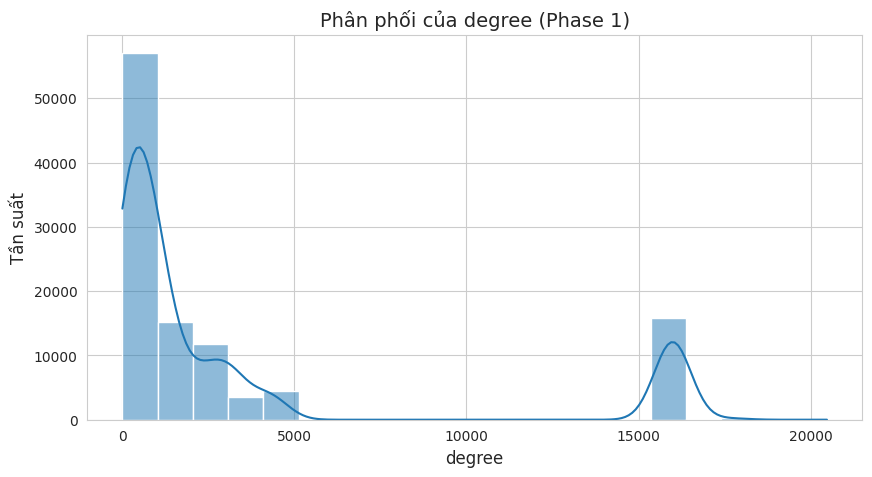

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


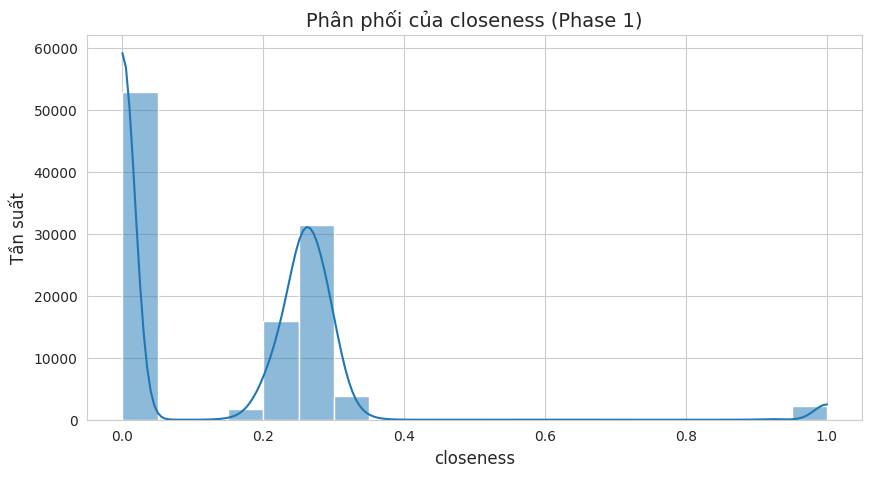

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


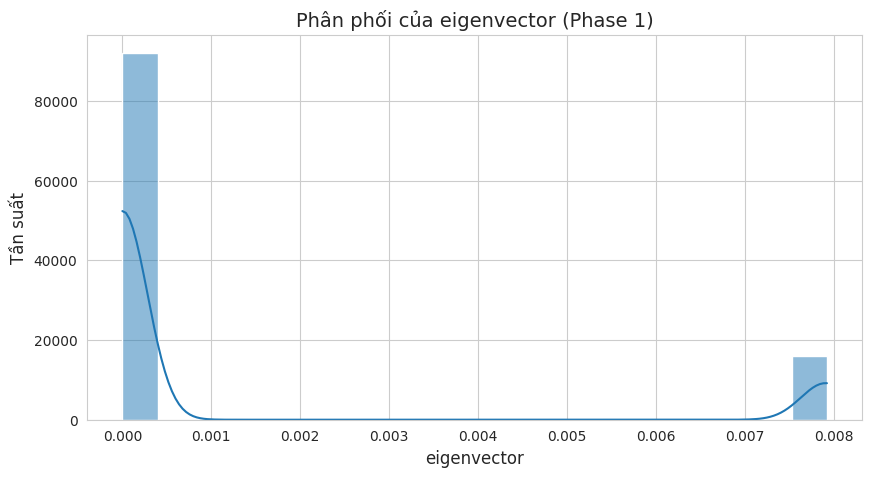


--- Phân tích cụm (Cluster) ---

--- Kiểm tra dữ liệu cho biểu đồ cụm ---
Số lượng giá trị duy nhất của 'cluster': 53713
Phân phối của 'cluster':
cluster
9        1751
563       937
137       893
15        781
173       769
         ... 
18410       1
18411       1
18412       1
18413       1
18401       1
Name: count, Length: 53713, dtype: int64
Số lượng giá trị duy nhất của 'label_encoded': 5
Phân phối của 'label_encoded':
label_encoded
0    58407
1    27609
2    14909
3     5381
4     1816
Name: count, dtype: int64
NaN trong 'cluster': 0
NaN trong 'label_encoded': 0
Kiểu dữ liệu của 'cluster': int64
Kiểu dữ liệu của 'label_encoded': int64
Đủ dữ liệu đa dạng để vẽ biểu đồ cụm và nhãn.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cấu hình hiển thị cho đồ thị
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Đường dẫn cơ sở đến thư mục chứa dữ liệu của bạn
base_data_path = "/kaggle/input/enrich-data-node-clustering"

# Số lượng phase
num_phases = 4

# DataFrame tích lũy các đặc trưng qua các phase
current_df = pd.DataFrame()

# Cột ID để merge giữa các phase (giả định 'Unnamed: 0' là ID duy nhất)
ID_COLUMN = 'record_id'

for phase_num in range(1, num_phases + 1):
    print(f"\n" + "="*80)
    print(f"### 🚀 BẮT ĐẦU PHÂN TÍCH EDA CHO PHASE {phase_num} ###")
    print("="*80)

    # Xây dựng đường dẫn file cho phase hiện tại
    # LƯU Ý: Đảm bảo đây là đường dẫn đến file DỮ LIỆU ĐÃ LÀM GIÀU, KHÔNG phải ma trận tương quan.
    file_path = os.path.join(base_data_path, f"phase{phase_num}/user_train_phase_{phase_num}.csv")
    
    try:
        new_phase_df = pd.read_csv(file_path)
        print(f"Đã đọc file: {file_path}")
        
        # Đổi tên cột 'Unnamed: 0' thành ID_COLUMN
        if 'Unnamed: 0' in new_phase_df.columns:
            new_phase_df.rename(columns={'Unnamed: 0': ID_COLUMN}, inplace=True)
            print(f"Đã đổi tên 'Unnamed: 0' thành '{ID_COLUMN}'.")
        
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file {file_path}. Bỏ qua Phase {phase_num}.")
        continue
    except Exception as e:
        print(f"Lỗi khi đọc file {file_path}: {e}. Bỏ qua Phase {phase_num}.")
        continue

    # Logic để tích lũy DataFrame
    if phase_num == 1:
        current_df = new_phase_df.copy()
    else:
        # Lấy danh sách các cột mới trong new_phase_df (trừ cột ID)
        new_cols_to_add = [
            col for col in new_phase_df.columns 
            if col not in current_df.columns and col != ID_COLUMN
        ]
        
        if new_cols_to_add:
            print(f"Các đặc trưng mới được thêm vào từ Phase {phase_num}: {new_cols_to_add}")
            
            if ID_COLUMN in current_df.columns and ID_COLUMN in new_phase_df.columns:
                # Chỉ chọn cột ID và các cột mới từ new_phase_df để merge
                cols_to_merge_from_new = [ID_COLUMN] + new_cols_to_add
                current_df = pd.merge(current_df, new_phase_df[cols_to_merge_from_new], on=ID_COLUMN, how='left')
                print(f"Đã merge {len(new_cols_to_add)} đặc trưng mới vào DataFrame tích lũy.")
            else:
                print(f"Cảnh báo: Không thể merge Phase {phase_num} do thiếu cột '{ID_COLUMN}'. Bỏ qua việc thêm đặc trưng mới.")
        else:
            print(f"Không có đặc trưng mới nào từ Phase {phase_num} để thêm vào DataFrame tích lũy.")
            
    print(f"\n--- Cấu trúc DataFrame sau khi tích lũy cho Phase {phase_num} ---")
    current_df.info()
    print(f"Số lượng bản ghi: {current_df.shape[0]}, Số lượng đặc trưng: {current_df.shape[1]}")

    # Xác định các cột phân loại và số
    categorical_cols = []
    numeric_cols = []

    # Danh sách các cột đã biết là phân loại hoặc nhị phân (tùy thuộc vào dữ liệu thực tế)
    known_categorical_or_binary = [
        'school', 'certificate', 'assignment', 'video', 'exam', 'cluster', 
        'exercise_langugage_binary_mean_1', # Có thể có hậu tố số cho các phase khác
        'label_encoded'
    ]
    # Thêm các cột nhị phân/phân loại theo phase
    for i in range(1, phase_num + 1):
        known_categorical_or_binary.extend([f'exercise_langugage_binary_mean_{i}'])

    for col in current_df.columns:
        if col == ID_COLUMN: # Bỏ qua cột ID
            continue
        # Nếu cột có ít giá trị duy nhất và không phải dạng 'total_words' hay 'total_score'
        # và là kiểu số nguyên, hoặc nằm trong danh sách đã biết
        if current_df[col].dtype == 'object':
             categorical_cols.append(col) # Các cột object luôn là phân loại
        elif col in known_categorical_or_binary:
            categorical_cols.append(col)
        elif current_df[col].nunique() < 10 and current_df[col].dtype == 'float64' and not any(kw in col for kw in ['total_words', 'score', 'count', 'sum']):
            # Heuristic: ít giá trị duy nhất và không phải là tổng/số đếm
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)

    # Loại bỏ các cột phân loại đã được xử lý (vd: school_count_map -> đã thành số) nếu cần
    # Đối với ví dụ này, chúng ta sẽ phân tích dựa trên kiểu dữ liệu hiện tại
    
    print(f"\n--- Phân loại Đặc trưng cho Phase {phase_num} ---")
    print(f"Đặc trưng số ({len(numeric_cols)}): {numeric_cols}")
    print(f"Đặc trưng phân loại ({len(categorical_cols)}): {categorical_cols}")

    # --- Thống kê đặc trưng số ---
    print("\n## 1. Thống kê đặc trưng số (Descriptive Statistics) ##")
    if numeric_cols:
        print(current_df[numeric_cols].describe().T)
    else:
        print("Không có đặc trưng số nào để thống kê.")

    # --- Thống kê đặc trưng phân loại ---
    print("\n## 2. Thống kê đặc trưng phân loại ##")
    if categorical_cols:
        for col in categorical_cols:
            print(f"\n--- Phân phối của '{col}' ---")
            print(current_df[col].value_counts())
            # Nếu là 'label_encoded', kiểm tra mất cân bằng lớp
            if col == 'label_encoded':
                print(f"Phân phối nhãn: {current_df[col].value_counts(normalize=True)}")
                if current_df[col].nunique() > 1: # Đảm bảo có ít nhất 2 lớp
                    if current_df[col].value_counts(normalize=True).min() < 0.2: # Ngưỡng 20%
                        print("⚠️ Cảnh báo: Lớp bị mất cân bằng nghiêm trọng!")
    else:
        print("Không có đặc trưng phân loại nào để thống kê.")

    # --- Kiểm tra giá trị thiếu ---
    print("\n## 3. Kiểm tra giá trị thiếu ##")
    missing_values = current_df.isnull().sum()
    missing_percentage = (current_df.isnull().sum() / len(current_df)) * 100
    missing_info = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage (%)': missing_percentage})
    missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage (%)', ascending=False)
    
    if not missing_info.empty:
        print(missing_info)
        print("⚠️ Cảnh báo: Có giá trị thiếu trong dữ liệu. Cần xử lý trước khi mô hình hóa.")
    else:
        print("Không có giá trị thiếu trong DataFrame này.")

    # --- Phân tích đặc trưng đồ thị và Trực quan hóa ---
    print("\n## 4. Phân tích đặc trưng đồ thị & Trực quan hóa ##")
    graph_features = [col for col in ['degree', 'closeness', 'eigenvector', 'cluster'] if col in current_df.columns]

    if graph_features:
        print("\n--- Phân phối của Degree, Closeness, Eigenvector ---")
        for feature in ['degree', 'closeness', 'eigenvector']:
            if feature in current_df.columns:
                plt.figure(figsize=(10, 5))
                sns.histplot(current_df[feature], kde=True, bins=min(len(current_df[feature].unique()), 20))
                plt.title(f'Phân phối của {feature} (Phase {phase_num})', fontsize=14)
                plt.xlabel(feature, fontsize=12)
                plt.ylabel('Tần suất', fontsize=12)
                plt.show()

        print("\n--- Phân tích cụm (Cluster) ---")
        print("\n--- Kiểm tra dữ liệu cho biểu đồ cụm ---")
        if 'cluster' in current_df.columns and 'label_encoded' in current_df.columns:
            print(f"Số lượng giá trị duy nhất của 'cluster': {current_df['cluster'].nunique()}")
            print(f"Phân phối của 'cluster':\n{current_df['cluster'].value_counts()}")
            print(f"Số lượng giá trị duy nhất của 'label_encoded': {current_df['label_encoded'].nunique()}")
            print(f"Phân phối của 'label_encoded':\n{current_df['label_encoded'].value_counts()}")
            
            # Kiểm tra giá trị thiếu
            print(f"NaN trong 'cluster': {current_df['cluster'].isnull().sum()}")
            print(f"NaN trong 'label_encoded': {current_df['label_encoded'].isnull().sum()}")
            
            # Kiểm tra kiểu dữ liệu
            print(f"Kiểu dữ liệu của 'cluster': {current_df['cluster'].dtype}")
            print(f"Kiểu dữ liệu của 'label_encoded': {current_df['label_encoded'].dtype}")

            if current_df['cluster'].nunique() > 1 and current_df['label_encoded'].nunique() > 1:
                print("Đủ dữ liệu đa dạng để vẽ biểu đồ cụm và nhãn.")
                plt.figure(figsize=(12, 7))
                sns.countplot(data=current_df, x='cluster', hue='label_encoded', palette='viridis')
                plt.title(f'Số lượng bản ghi theo cụm và nhãn (Phase {phase_num})', fontsize=16)
                plt.xlabel('Cụm', fontsize=14)
                plt.ylabel('Số lượng bản ghi', fontsize=14)
                # Đảm bảo legend có đủ labels nếu có hơn 2 lớp
                unique_labels = current_df['label_encoded'].unique()
                if 0 in unique_labels and 1 in unique_labels:
                    plt.legend(title='Nhãn', labels=['Nhãn 0', 'Nhãn 1'])
                else:
                    plt.legend(title='Nhãn') # Để Seaborn tự động tạo nếu labels khác
                plt.show()
            else:
                print("Không đủ sự đa dạng trong 'cluster' hoặc 'label_encoded' để vẽ biểu đồ có ý nghĩa.")
                if current_df['cluster'].nunique() <= 1:
                    print("- Tất cả bản ghi nằm trong cùng một cụm hoặc không có cụm.")
                if current_df['label_encoded'].nunique() <= 1:
                    print("- Tất cả bản ghi có cùng một nhãn.")
        else:
            print("Không thể phân tích cụm do thiếu cột 'cluster' hoặc 'label_encoded'.")
    else:
        print("Không có đặc trưng đồ thị nào để phân tích trong Phase này.")


    # --- Ma trận tương quan & Heatmap ---
    print("\n## 5. Ma trận Tương quan & Heatmap ##")
    
    # Chỉ chọn các cột số để tính tương quan
    numeric_df_for_corr = current_df[numeric_cols].copy()
    
    num_features_in_corr = numeric_df_for_corr.shape[1]
    if num_features_in_corr == 0:
        print("Không có đặc trưng số nào để tính tương quan.")
    else:
        # Điều chỉnh kích thước heatmap dựa trên số lượng đặc trưng
        figsize_corr = (max(15, num_features_in_corr * 0.6), max(12, num_features_in_corr * 0.5))

        # Pearson Correlation
        plt.figure(figsize=figsize_corr)
        pearson_corr = numeric_df_for_corr.corr(method='pearson')
        sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
        plt.title(f'Ma trận Tương quan Pearson (Phase {phase_num})', fontsize=18)
        plt.xticks(rotation=90, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Spearman Correlation
        plt.figure(figsize=figsize_corr)
        spearman_corr = numeric_df_for_corr.corr(method='spearman')
        sns.heatmap(spearman_corr, annot=False, cmap='viridis', fmt='.2f', linewidths=.5)
        plt.title(f'Ma trận Tương quan Spearman (Phase {phase_num})', fontsize=18)
        plt.xticks(rotation=90, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        print(f"\n--- Top 10 Đặc trưng Tương quan với 'label_encoded' (Pearson) - Phase {phase_num} ---")
        if 'label_encoded' in pearson_corr.columns:
            print(pearson_corr['label_encoded'].sort_values(key=abs, ascending=False).head(10)) 
        else:
            print("'label_encoded' không có trong ma trận tương quan của phase này.")

        print(f"\n--- Top 10 Đặc trưng Tương quan với 'label_encoded' (Spearman) - Phase {phase_num} ---")
        if 'label_encoded' in spearman_corr.columns:
            print(spearman_corr['label_encoded'].sort_values(key=abs, ascending=False).head(10)) 
        else:
            print("'label_encoded' không có trong ma trận tương quan của phase này.")

        # --- 5. Trực quan hóa Boxplot & Violinplot cho đặc trưng đồ thị ---
    graph_numeric_features = ['degree', 'closeness', 'eigenvector']
    for g_feature in graph_numeric_features:
        if g_feature in current_df.columns and 'cluster' in current_df.columns:
            plt.figure(figsize=(10, 5))
            sns.boxplot(x='cluster', y=g_feature, data=current_df, palette='Set3')
            plt.title(f'Boxplot của {g_feature} theo cụm (Phase {phase_num})')
            plt.xlabel('Cụm')
            plt.ylabel(g_feature)
            plt.show()
            
            plt.figure(figsize=(10, 5))
            sns.violinplot(x='cluster', y=g_feature, data=current_df, palette='Pastel2')
            plt.title(f'Violinplot của {g_feature} theo cụm (Phase {phase_num})')
            plt.xlabel('Cụm')
            plt.ylabel(g_feature)
            plt.show()

    # --- 6. Biểu đồ Heatmap ma trận tương quan ---
    print("\n## 6. Ma trận tương quan của các đặc trưng số ##")
    if len(numeric_cols) >= 2:
        corr_matrix = current_df[numeric_cols].corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
        plt.title(f'Ma trận tương quan (Phase {phase_num})')
        plt.show()
    else:
        print("Không đủ đặc trưng số để vẽ heatmap.")

    # --- 7. PCA 2D để kiểm tra sự tách biệt giữa các cụm ---
    print("\n## 7. PCA để kiểm tra tách biệt giữa các cụm ##")
    try:
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA

        # Chỉ dùng đặc trưng số, loại bỏ NaN
        pca_data = current_df[numeric_cols].dropna()
        if 'cluster' in current_df.columns:
            cluster_labels = current_df.loc[pca_data.index, 'cluster']
        else:
            cluster_labels = None

        if not pca_data.empty and pca_data.shape[1] >= 2:
            scaler = StandardScaler()
            pca_scaled = scaler.fit_transform(pca_data)

            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(pca_scaled)

            plt.figure(figsize=(10, 6))
            if cluster_labels is not None:
                sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=cluster_labels, palette='tab10', alpha=0.7)
                plt.legend(title='Cluster')
            else:
                sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], alpha=0.7)
            plt.title(f'PCA - Phân tách cụm trong không gian 2D (Phase {phase_num})')
            plt.xlabel('PCA 1')
            plt.ylabel('PCA 2')
            plt.show()
        else:
            print("Không đủ dữ liệu để thực hiện PCA.")
    except Exception as e:
        print(f"Lỗi khi thực hiện PCA: {e}")

    # --- 8. Phân tích label_encoded theo các cụm ---
    if 'label_encoded' in current_df.columns and 'cluster' in current_df.columns:
        print("\n## 8. Phân tích tỷ lệ nhãn trong từng cụm ##")
        cluster_label_dist = pd.crosstab(current_df['cluster'], current_df['label_encoded'], normalize='index')
        print(cluster_label_dist)
        cluster_label_dist.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
        plt.title(f'Tỷ lệ nhãn theo cụm (Phase {phase_num})')
        plt.xlabel('Cụm')
        plt.ylabel('Tỷ lệ (%)')
        plt.legend(title='Nhãn')
        plt.show()

            
    print(f"\n" + "="*80)
    print(f"### ✅ KẾT THÚC PHÂN TÍCH EDA CHO PHASE {phase_num} ###")
    print("="*80)

print("\n--- Hoàn tất tất cả các Phase EDA ---")

# --- Kết luận tổng thể (sau khi chạy hết các phase) ---
print("\n## Kết luận Tổng thể cho Node Cluster và Tích hợp Đặc trưng ##")
print("Sau khi phân tích EDA qua từng phase, chúng ta có thể rút ra một số nhận xét:")

print("\n### 1. Phân phối của các đặc trưng đồ thị (degree, closeness, eigenvector) ###")
print("- Các biểu đồ histogram cho thấy hình dạng phân phối của các đặc trưng này thay đổi qua các phase. Điều này có thể phản ánh sự phát triển của mạng lưới tương tác hoặc cách người dùng/nội dung được thêm vào/kết nối qua thời gian.")
print("- Độ lệch và sự hiện diện của giá trị ngoại lai trong các đặc trưng đồ thị cho thấy một số nút (người dùng/video) có thể có vai trò hoặc mức độ kết nối đặc biệt trong mạng.")
print("- Ý nghĩa: 'Degree' cao thường liên quan đến các nút có nhiều kết nối (người dùng hoạt động, video phổ biến). 'Closeness' cao cho thấy nút đó dễ dàng tiếp cận các nút khác. 'Eigenvector' cao biểu thị kết nối với các nút quan trọng khác.")

print("\n### 2. Đánh giá khả năng phân tách của cụm (cluster) ###")
print("- Biểu đồ cột phân phối nhãn theo cụm cho thấy liệu các cụm có chứa tỷ lệ nhãn (label) khác nhau đáng kể hay không.")
print("- Nếu một cụm có tỷ lệ 'label=1' cao hơn rõ rệt so với cụm khác, điều này cho thấy **cluster** là một đặc trưng hữu ích để phân biệt các nhãn mục tiêu.")
print("- Điều này cung cấp bằng chứng ban đầu về khả năng phân đoạn người dùng hoặc nội dung dựa trên cấu trúc mạng của họ.")

print("\n### 3. Giá trị của các đặc trưng đồ thị ###")
print("- Các đặc trưng đồ thị (degree, closeness, eigenvector, cluster) cung cấp thông tin ngữ cảnh phong phú về mối quan hệ và cấu trúc trong dữ liệu mà các đặc trưng hành vi đơn thuần không thể nắm bắt được.")
print("- Chúng có thể giúp mô hình hiểu được vai trò của người dùng trong một mạng lưới tương tác hoặc cách các video được nhóm lại với nhau, từ đó cải thiện khả năng dự đoán.")
print("- Tương quan của chúng với các đặc trưng hành vi và đặc biệt là với `label_encoded` sẽ xác nhận giá trị bổ sung mà chúng mang lại.")

print("\n### 4. Nhận xét về quá trình tích hợp đặc trưng qua các phase ###")
print("- Việc tích lũy đặc trưng từ các phase trước cho phép chúng ta xây dựng một tập dữ liệu ngày càng toàn diện, nắm bắt được sự phát triển của hành vi và dữ liệu qua thời gian.")
print("- Sự xuất hiện của các đặc trưng với hậu tố số (ví dụ: `video_pause_count_1`, `video_pause_count_2`) là minh chứng cho việc này, cho phép phân tích sự thay đổi trong hành vi qua từng giai đoạn.")

print("\n--- Các bước tiếp theo ---")
print("Dựa trên kết quả EDA này, bạn có thể:")
print("- Xem xét xử lý các giá trị ngoại lai nếu chúng ảnh hưởng lớn đến phân tích hoặc mô hình hóa.")
print("- Xử lý mất cân bằng lớp nếu cột `label_encoded` có sự chênh lệch lớn.")
print("- Lựa chọn đặc trưng dựa trên tương quan và ý nghĩa domain để xây dựng mô hình học máy.")
print("- Khám phá sâu hơn các mối quan hệ đa biến giữa các đặc trưng quan trọng.")

In [ ]:
    # --- 5. Trực quan hóa Boxplot & Violinplot cho đặc trưng đồ thị ---
    graph_numeric_features = ['degree', 'closeness', 'eigenvector']
    for g_feature in graph_numeric_features:
        if g_feature in current_df.columns and 'cluster' in current_df.columns:
            plt.figure(figsize=(10, 5))
            sns.boxplot(x='cluster', y=g_feature, data=current_df, palette='Set3')
            plt.title(f'Boxplot của {g_feature} theo cụm (Phase {phase_num})')
            plt.xlabel('Cụm')
            plt.ylabel(g_feature)
            plt.show()
            
            plt.figure(figsize=(10, 5))
            sns.violinplot(x='cluster', y=g_feature, data=current_df, palette='Pastel2')
            plt.title(f'Violinplot của {g_feature} theo cụm (Phase {phase_num})')
            plt.xlabel('Cụm')
            plt.ylabel(g_feature)
            plt.show()

    # --- 6. Biểu đồ Heatmap ma trận tương quan ---
    print("\n## 6. Ma trận tương quan của các đặc trưng số ##")
    if len(numeric_cols) >= 2:
        corr_matrix = current_df[numeric_cols].corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
        plt.title(f'Ma trận tương quan (Phase {phase_num})')
        plt.show()
    else:
        print("Không đủ đặc trưng số để vẽ heatmap.")

    # --- 7. PCA 2D để kiểm tra sự tách biệt giữa các cụm ---
    print("\n## 7. PCA để kiểm tra tách biệt giữa các cụm ##")
    try:
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA

        # Chỉ dùng đặc trưng số, loại bỏ NaN
        pca_data = current_df[numeric_cols].dropna()
        if 'cluster' in current_df.columns:
            cluster_labels = current_df.loc[pca_data.index, 'cluster']
        else:
            cluster_labels = None

        if not pca_data.empty and pca_data.shape[1] >= 2:
            scaler = StandardScaler()
            pca_scaled = scaler.fit_transform(pca_data)

            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(pca_scaled)

            plt.figure(figsize=(10, 6))
            if cluster_labels is not None:
                sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=cluster_labels, palette='tab10', alpha=0.7)
                plt.legend(title='Cluster')
            else:
                sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], alpha=0.7)
            plt.title(f'PCA - Phân tách cụm trong không gian 2D (Phase {phase_num})')
            plt.xlabel('PCA 1')
            plt.ylabel('PCA 2')
            plt.show()
        else:
            print("Không đủ dữ liệu để thực hiện PCA.")
    except Exception as e:
        print(f"Lỗi khi thực hiện PCA: {e}")

    # --- 8. Phân tích label_encoded theo các cụm ---
    if 'label_encoded' in current_df.columns and 'cluster' in current_df.columns:
        print("\n## 8. Phân tích tỷ lệ nhãn trong từng cụm ##")
        cluster_label_dist = pd.crosstab(current_df['cluster'], current_df['label_encoded'], normalize='index')
        print(cluster_label_dist)
        cluster_label_dist.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
        plt.title(f'Tỷ lệ nhãn theo cụm (Phase {phase_num})')
        plt.xlabel('Cụm')
        plt.ylabel('Tỷ lệ (%)')
        plt.legend(title='Nhãn')
        plt.show()


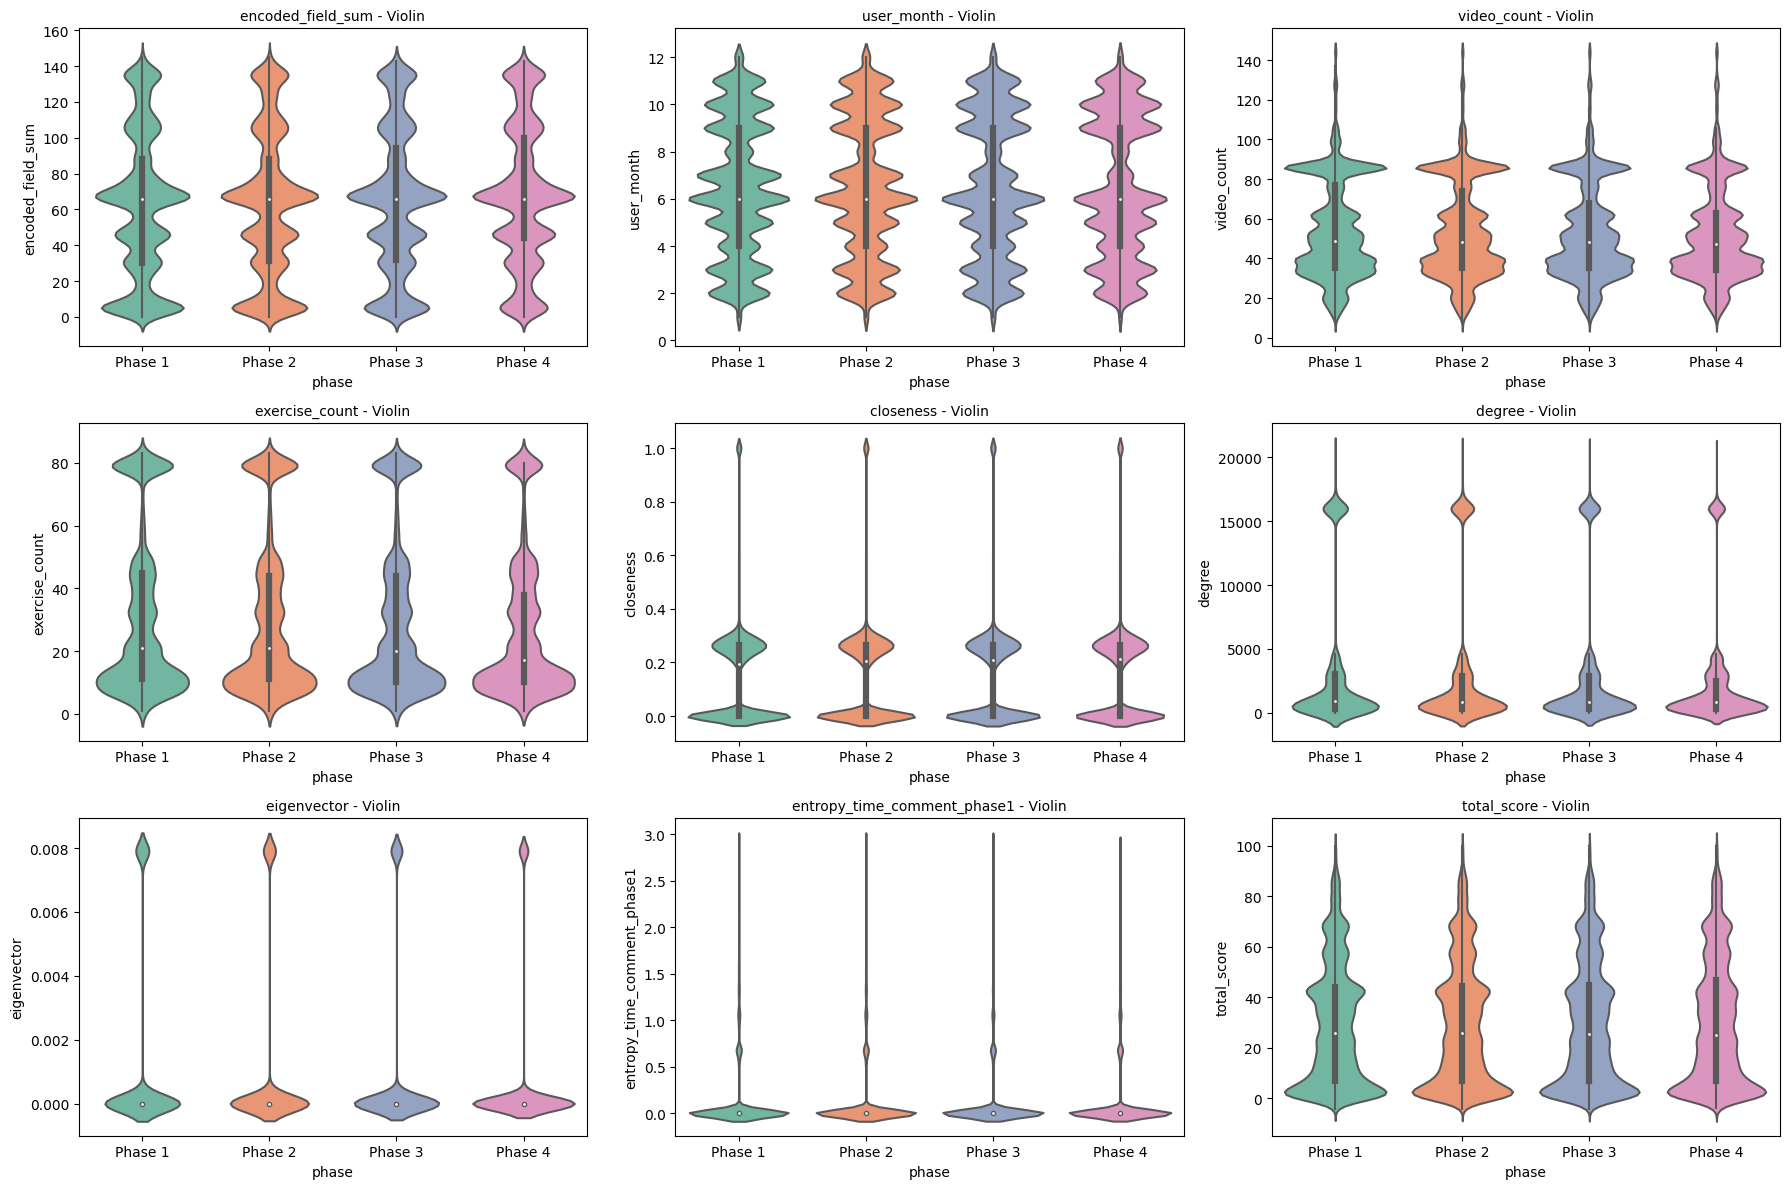

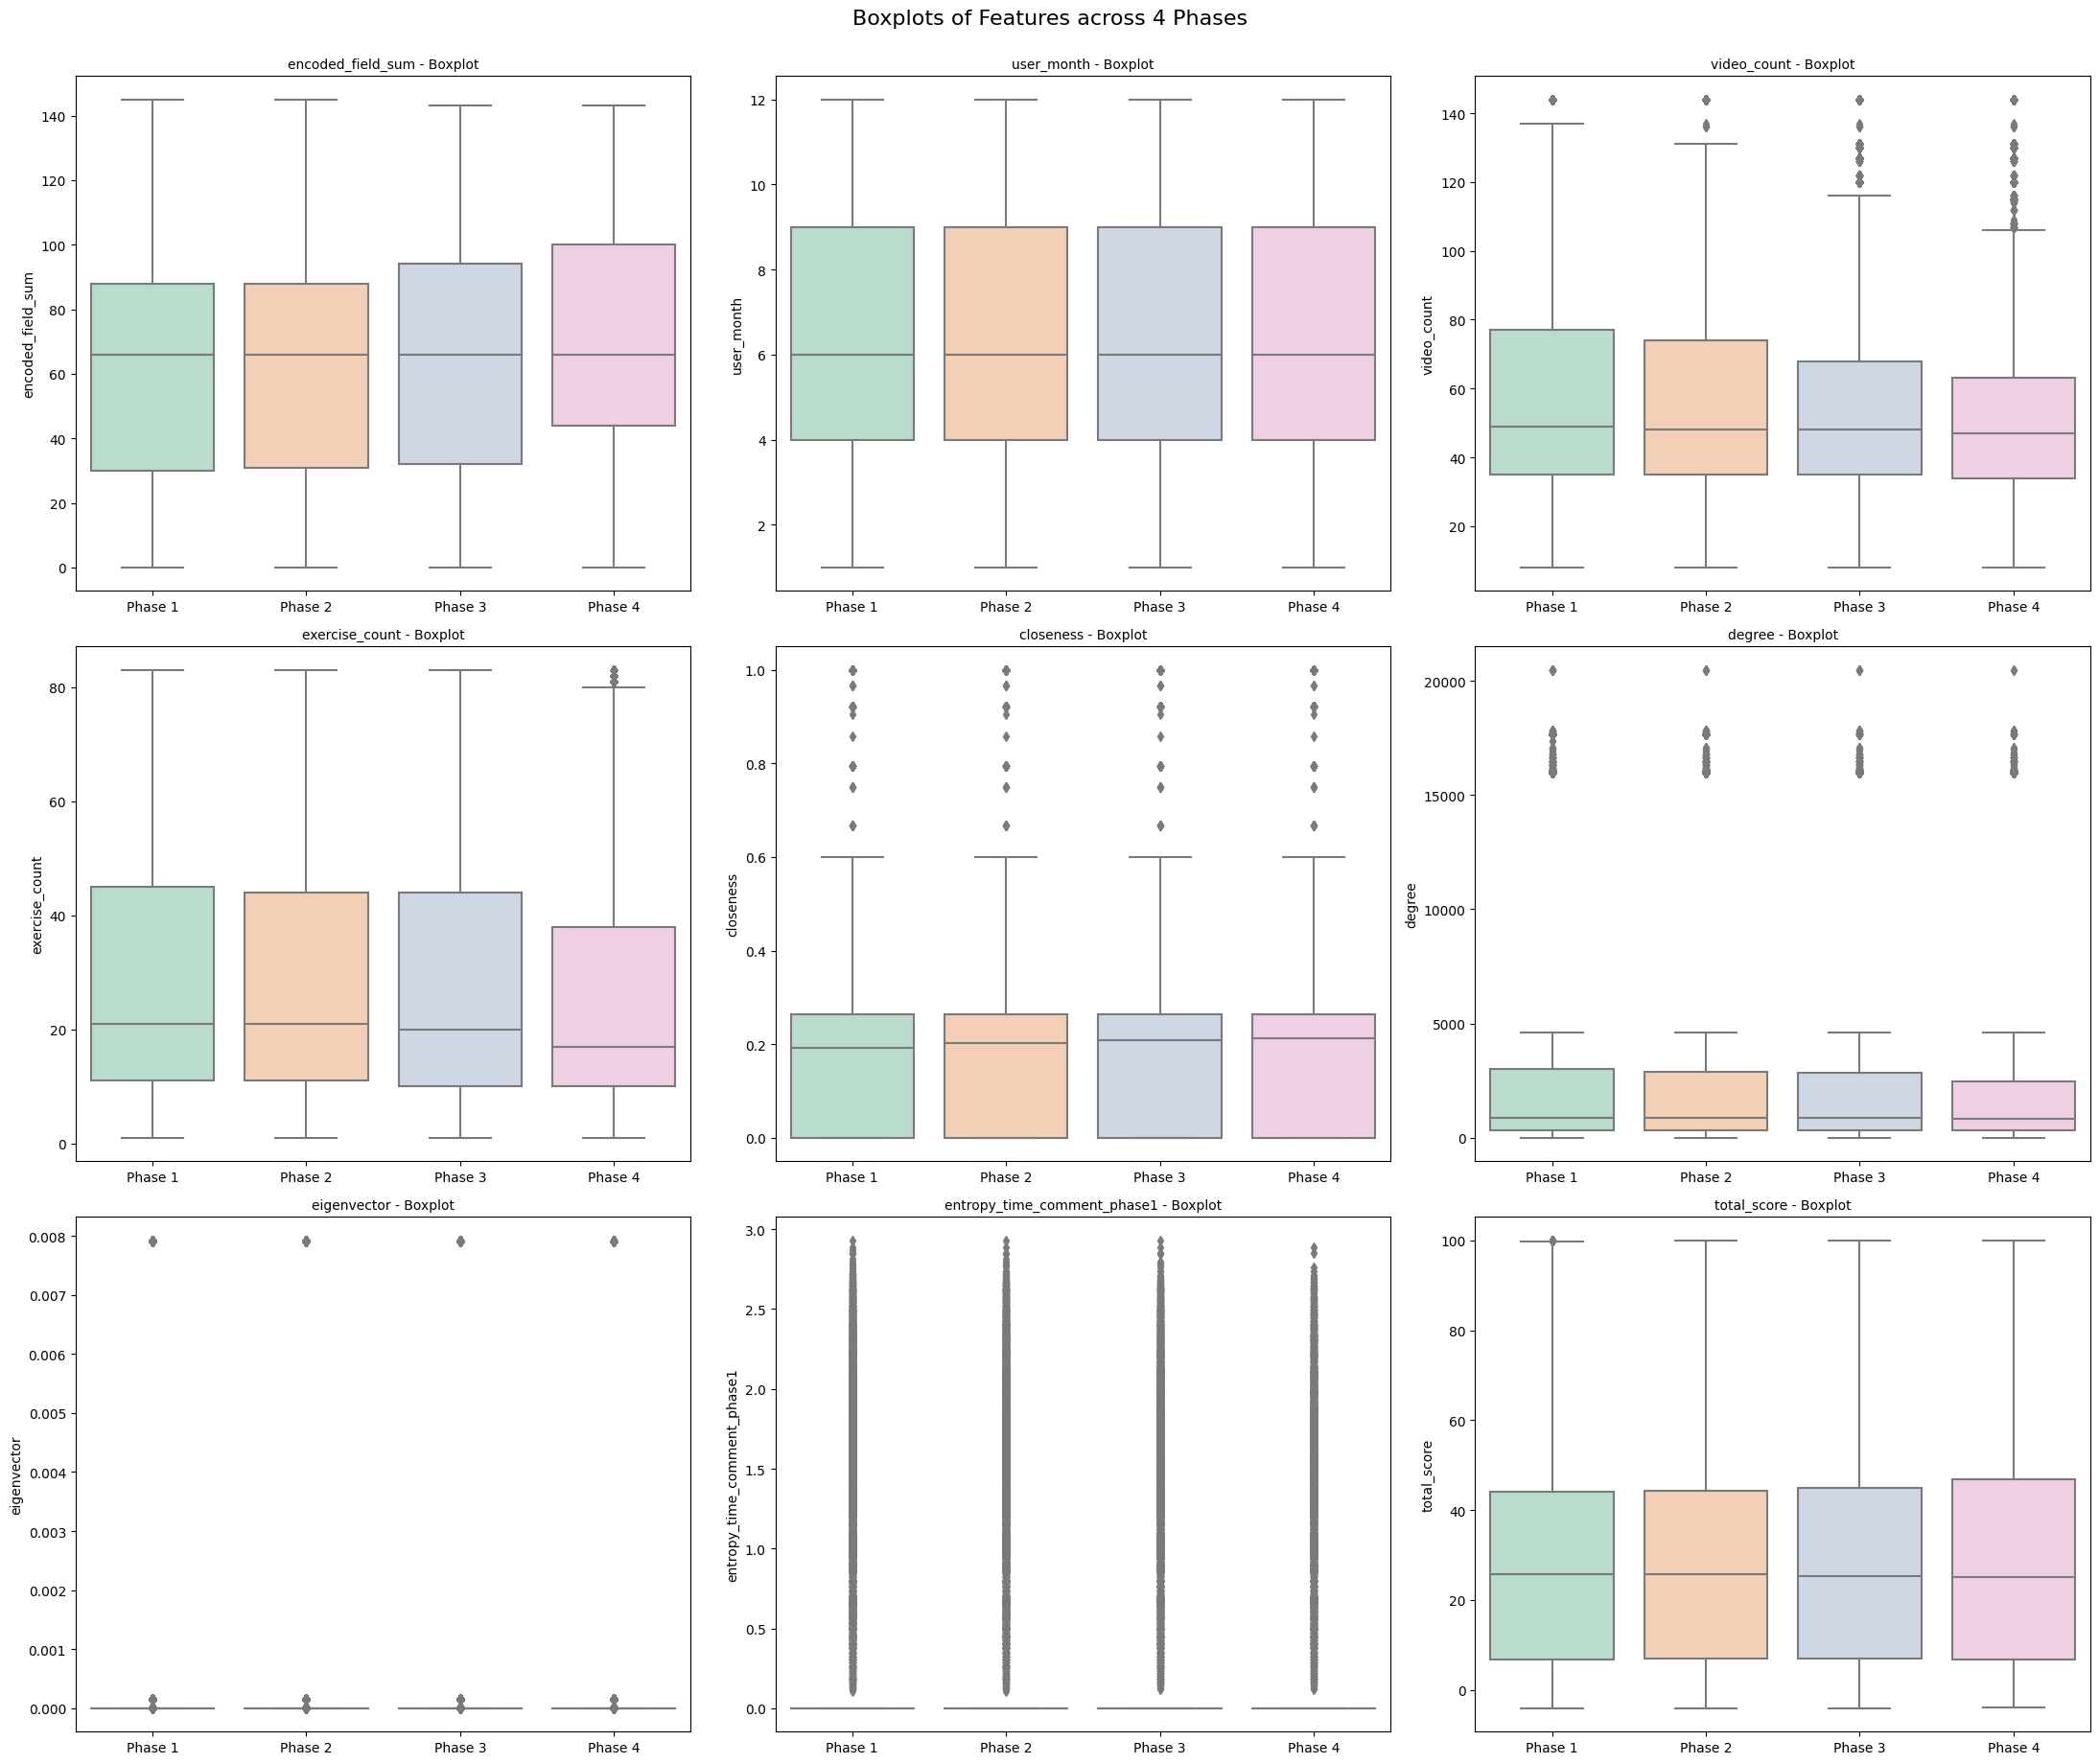

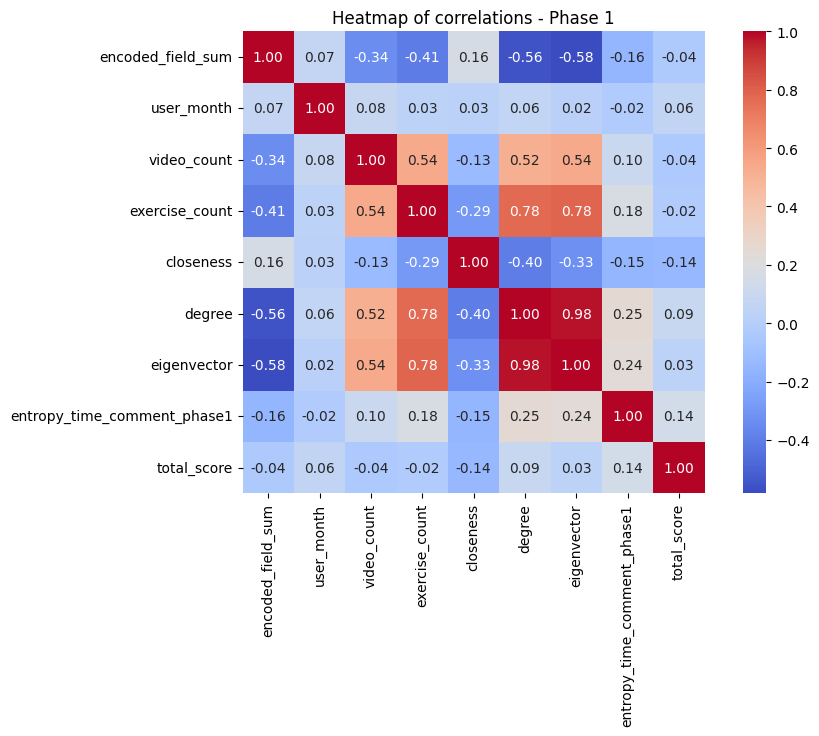

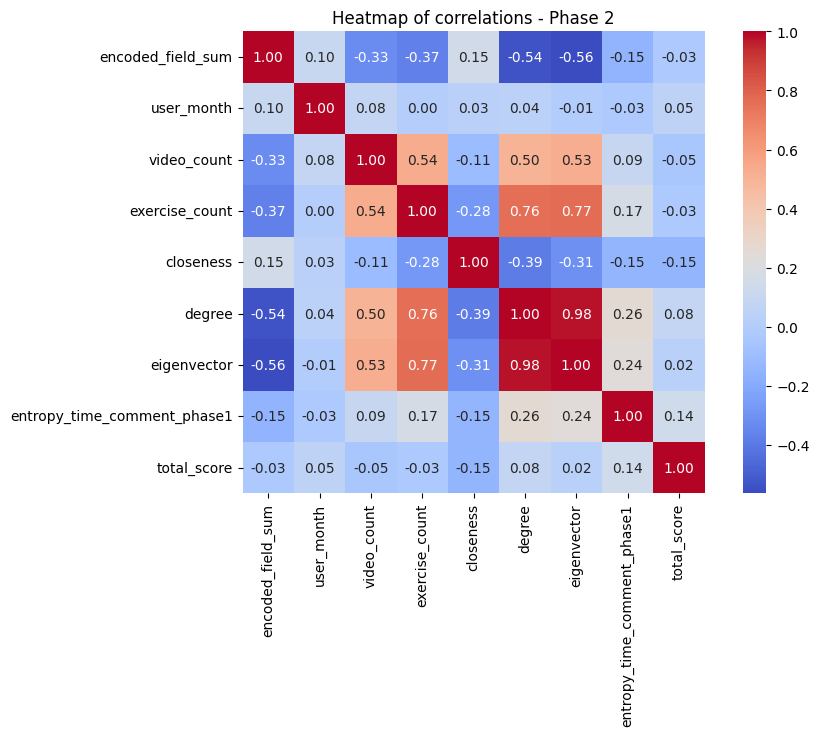

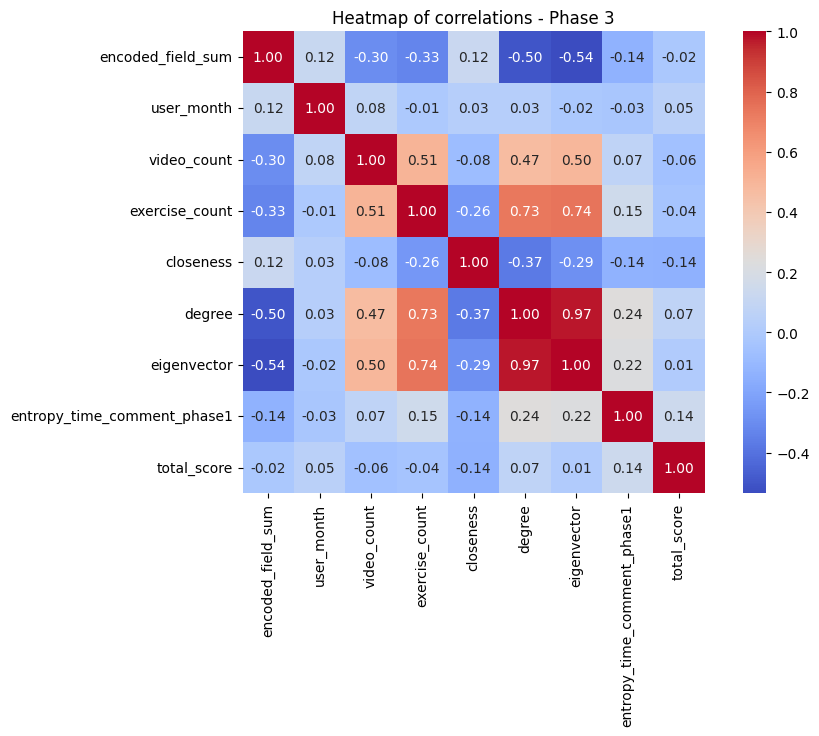

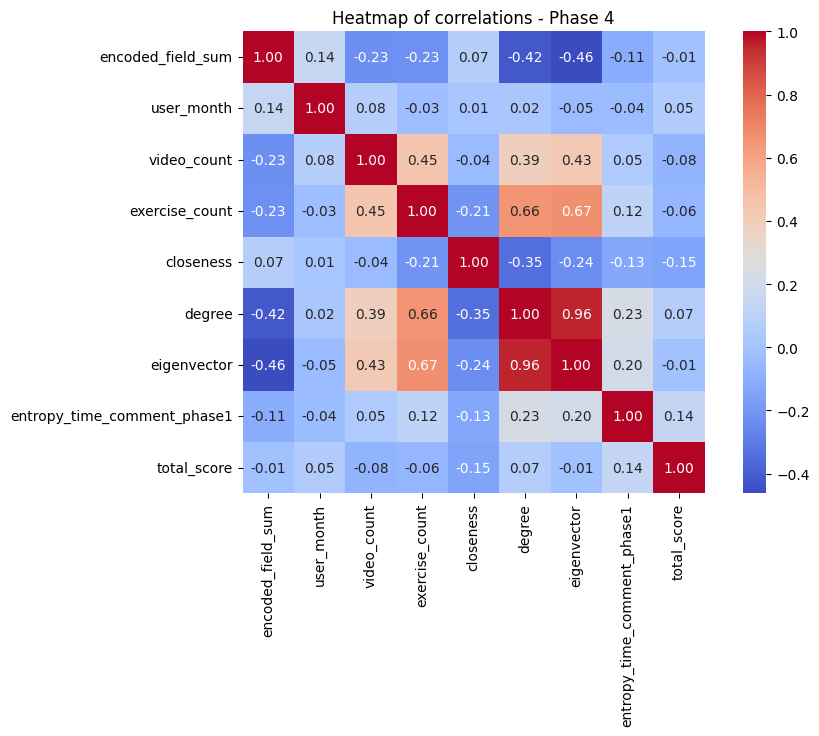

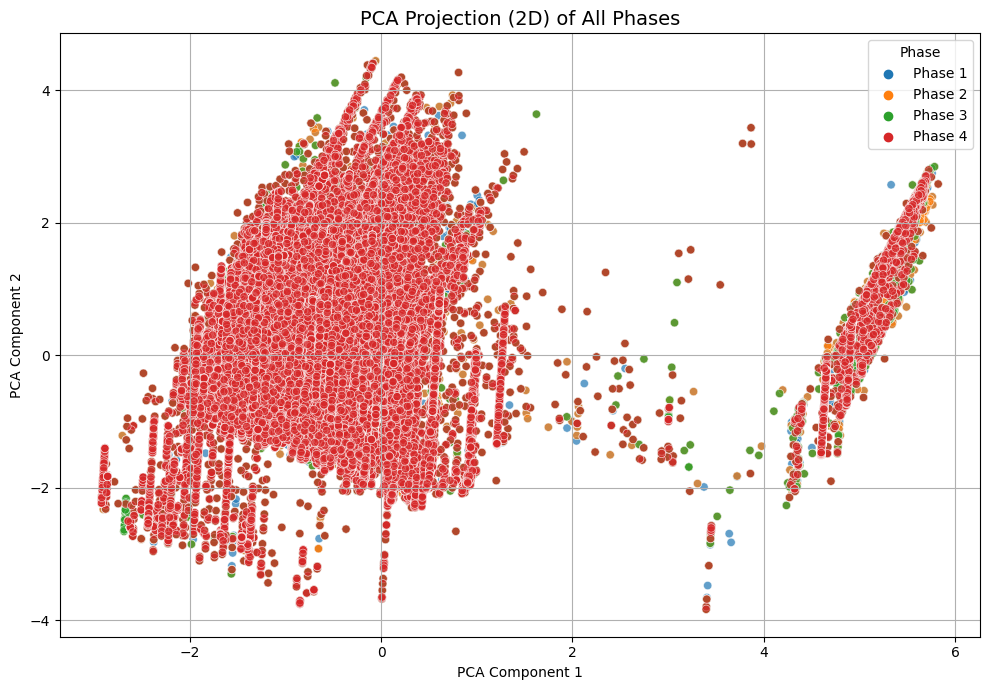

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

# --- Đọc dữ liệu từ 4 phase ---
phase_paths = {
    "Phase 1": "/kaggle/input/enrich-data-node-clustering/phase1/user_train_phase_1.csv",
    "Phase 2": "/kaggle/input/enrich-data-node-clustering/phase2/user_train_phase_2.csv",
    "Phase 3": "/kaggle/input/enrich-data-node-clustering/phase3/user_train_phase_3.csv",
    "Phase 4": "/kaggle/input/enrich-data-node-clustering/phase4/user_train_phase_4.csv"
}

dfs = []
for phase, path in phase_paths.items():
    df = pd.read_csv(path)
    df["phase"] = phase
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# --- Chọn các đặc trưng số có độ tương quan cao---
selected_features = [, "video_count", "exercise_count",
    "closeness", "degree", "eigenvector", "entropy_time_comment_phase1",
    "total_score"
]


# --- 1. Violin Plot ---
n_features = len(selected_features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, feature in enumerate(selected_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(data=combined_df, x="phase", y=feature, palette="Set2")
    plt.title(f"{feature} - Violin", fontsize=10)

plt.tight_layout()
plt.show()

# --- 2. Box Plot ---
plt.figure(figsize=(22, 18))
for i, feature in enumerate(selected_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(data=combined_df, x="phase", y=feature, palette="Pastel2")
    plt.title(f"{feature} - Boxplot", fontsize=10)
    plt.xlabel("")
    plt.ylabel(feature)
plt.tight_layout()
plt.suptitle("Boxplots of Features across 4 Phases", fontsize=16, y=1.02)
plt.show()

# --- 3. Heatmap correlation theo từng phase ---
for phase in combined_df['phase'].unique():
    plt.figure(figsize=(10, 6))
    phase_data = combined_df[combined_df['phase'] == phase][selected_features]
    corr = phase_data.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"Heatmap of correlations - {phase}")
    plt.show()

# --- 4. PCA giảm chiều (2D projection) ---
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[selected_features])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
combined_df['PCA1'] = pca_result[:, 0]
combined_df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=combined_df, x='PCA1', y='PCA2', hue='phase', palette='tab10', alpha=0.7)
plt.title("PCA Projection (2D) of All Phases", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Phase")
plt.grid(True)
plt.tight_layout()
plt.show()


📌 Thống kê mô tả các đặc trưng mạng theo từng phase:
        closeness                                                         \
            count      mean       std  min  25%       50%       75%  max   
phase                                                                      
Phase 1  108122.0  0.148994  0.180855  0.0  0.0  0.193178  0.263203  1.0   
Phase 2  101600.0  0.151765  0.182391  0.0  0.0  0.203504  0.263753  1.0   
Phase 3   94917.0  0.154201  0.184261  0.0  0.0  0.207846  0.264403  1.0   
Phase 4   83783.0  0.158495  0.185111  0.0  0.0  0.213559  0.264514  1.0   

           degree               ...                  eigenvector            \
            count         mean  ...     75%      max       count      mean   
phase                           ...                                          
Phase 1  108122.0  3340.950510  ...  3025.0  20474.0    108122.0  0.001180   
Phase 2  101600.0  3147.427480  ...  2894.0  20474.0    101600.0  0.001068   
Phase 3   94917.0  2858.

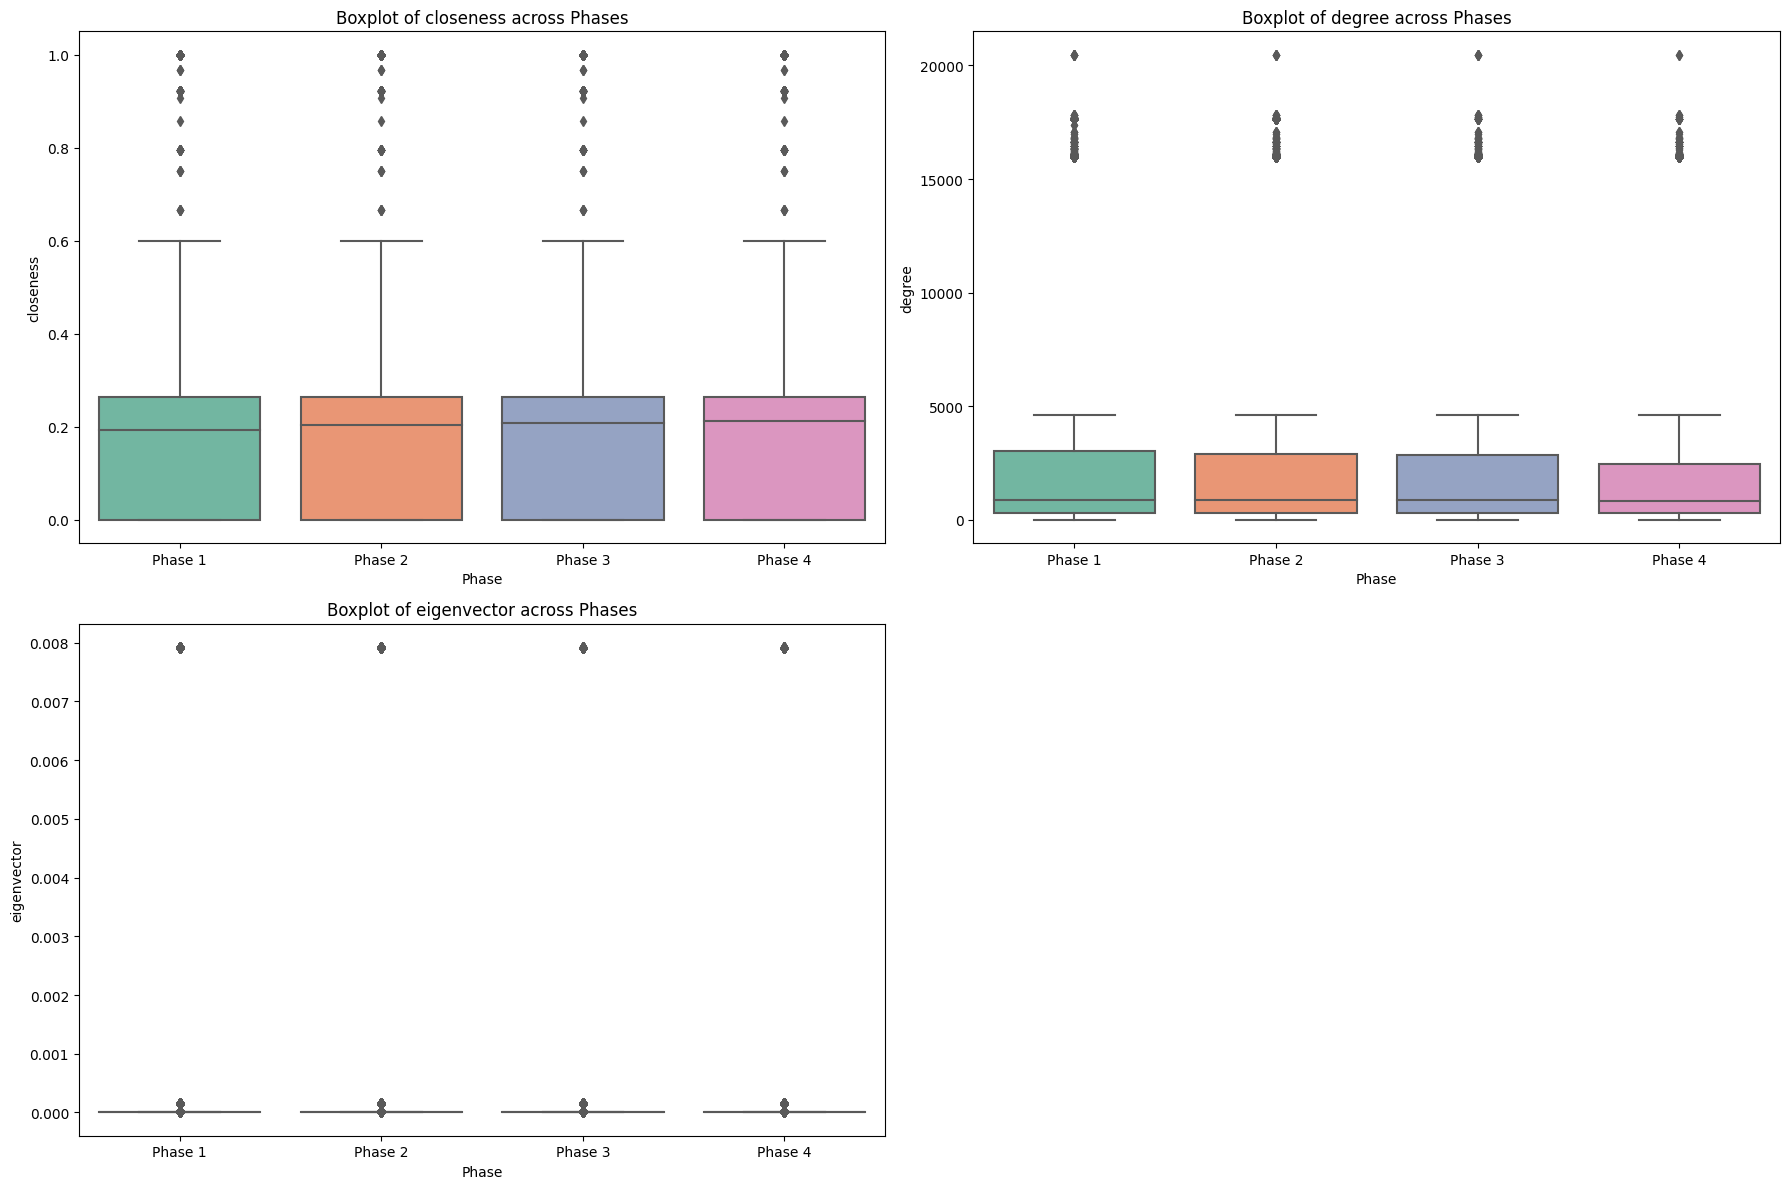

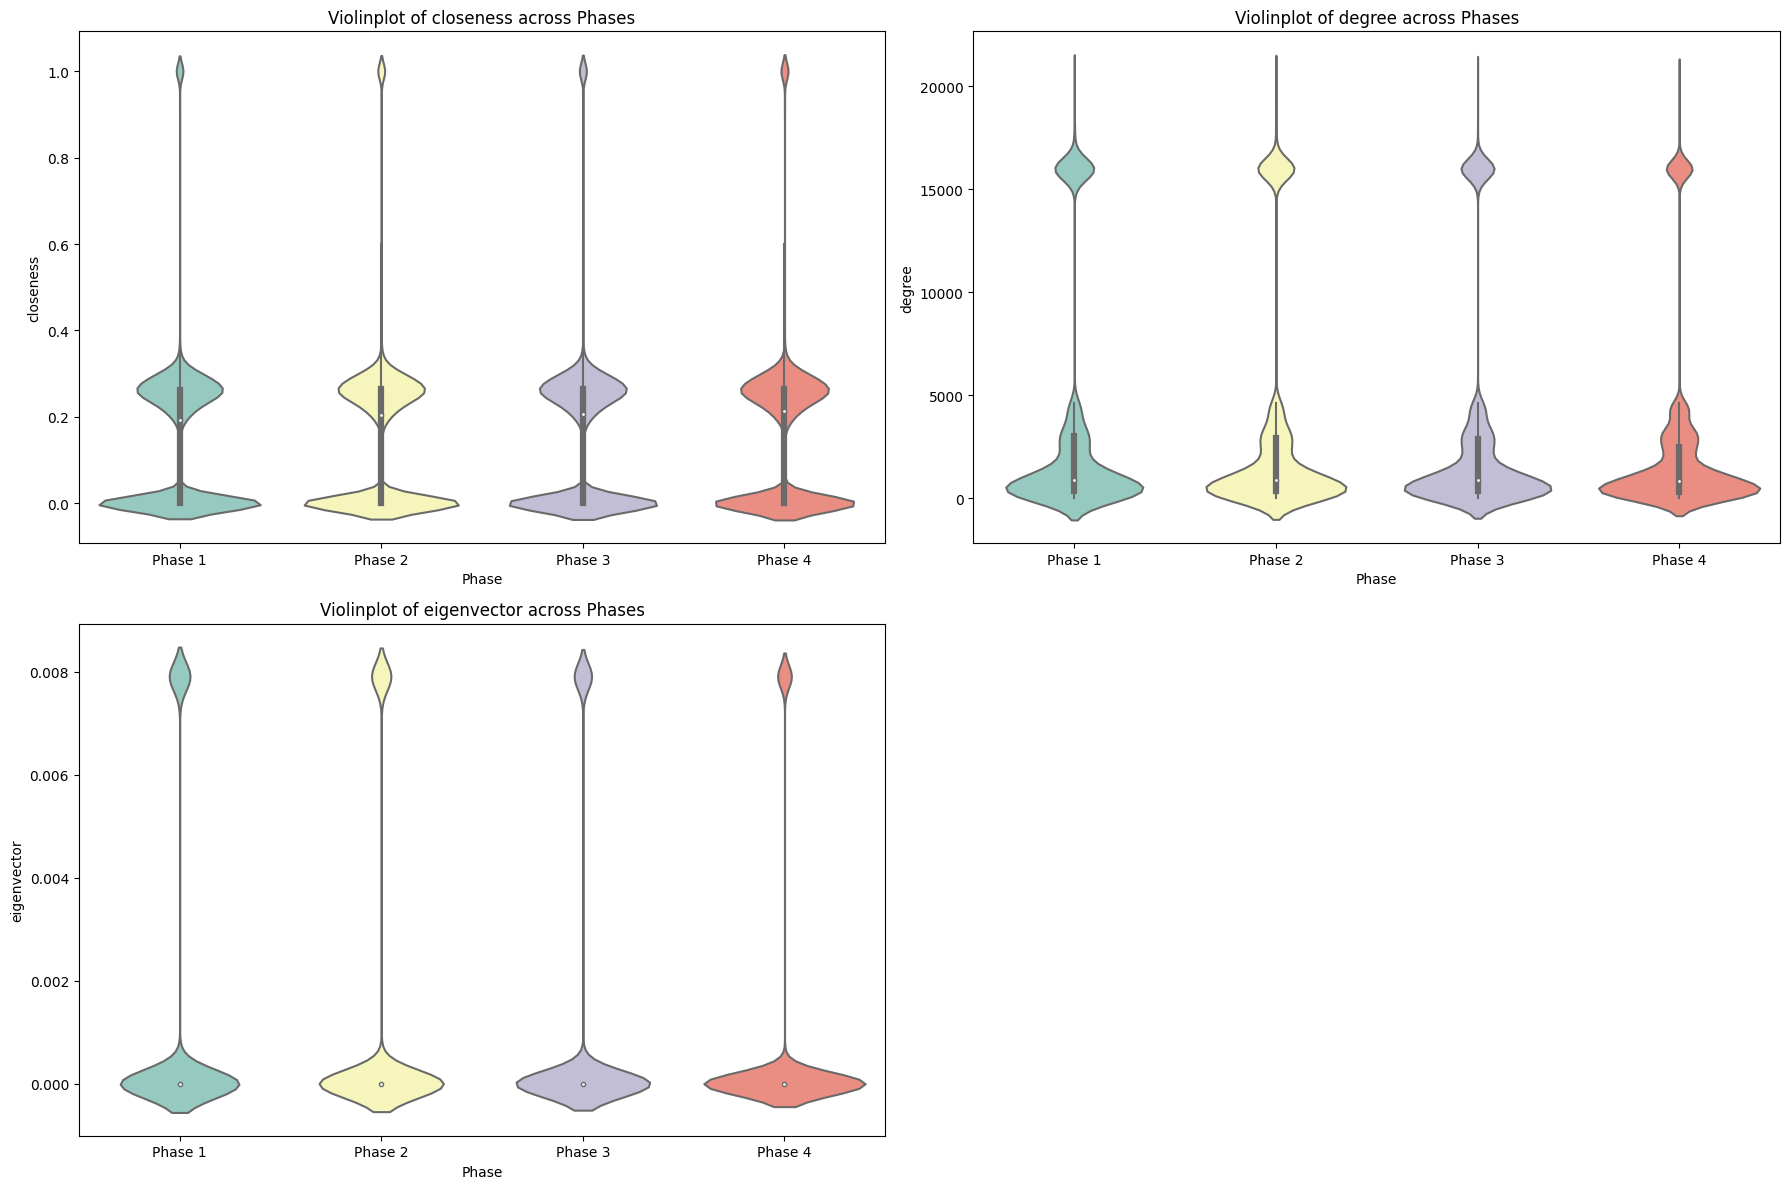

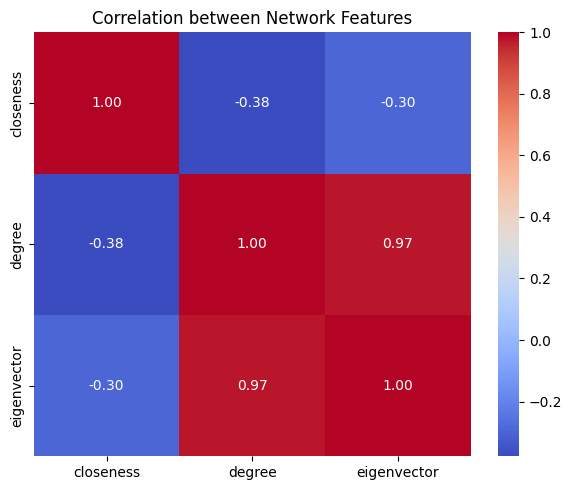

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Đọc dữ liệu và gộp lại ---
phase_paths = {
    "Phase 1": "/kaggle/input/enrich-data-node-clustering/phase1/user_train_phase_1.csv",
    "Phase 2": "/kaggle/input/enrich-data-node-clustering/phase2/user_train_phase_2.csv",
    "Phase 3": "/kaggle/input/enrich-data-node-clustering/phase3/user_train_phase_3.csv",
    "Phase 4": "/kaggle/input/enrich-data-node-clustering/phase4/user_train_phase_4.csv"
}

dfs = []
for phase, path in phase_paths.items():
    df = pd.read_csv(path)
    df["phase"] = phase
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# --- Lấy các đặc trưng mạng ---
network_features = ["closeness", "degree", "eigenvector"]

# --- 1. Thống kê mô tả theo từng phase ---
summary_stats = combined_df.groupby("phase")[network_features].describe()
print("📌 Thống kê mô tả các đặc trưng mạng theo từng phase:")
print(summary_stats)

# --- 2. Boxplot cho từng đặc trưng ---
plt.figure(figsize=(18, 12))
for i, feature in enumerate(network_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=combined_df, x="phase", y=feature, palette="Set2")
    plt.title(f"Boxplot of {feature} across Phases")
    plt.xlabel("Phase")
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

# --- 3. Violinplot cho từng đặc trưng ---
plt.figure(figsize=(18, 12))
for i, feature in enumerate(network_features):
    plt.subplot(2, 2, i + 1)
    sns.violinplot(data=combined_df, x="phase", y=feature, palette="Set3")
    plt.title(f"Violinplot of {feature} across Phases")
    plt.xlabel("Phase")
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

# --- 4. Heatmap tương quan giữa 3 đặc trưng ---
plt.figure(figsize=(6, 5))
corr_matrix = combined_df[network_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Network Features")
plt.tight_layout()
plt.show()
